# Woman's Health and Wearable Analytics
## by Karin Wiberg

## Background

[Health practitioners](https://www.acog.org/clinical/clinical-guidance/committee-opinion/articles/2015/12/menstruation-in-girls-and-adolescents-using-the-menstrual-cycle-as-a-vital-sign) consider the infradian rythm, the menstrual cycle, as the 5th vital sign. Hence, tracking the infradian rythm in woman is key to optimize health and performance. 

The [Oura ring](https://ouraring.com) is a consumer wearable which measures nighttime health data, as the resting state gives a good indication of the overall health of a person. The Oura ring can be used to [understand](https://blog.ouraring.com/your-menstrual-cycle/) how the infradian rythm affects the body and to find the timing of ovulation. 

The aim of the data visualization is to make a personalized health assessment of physiological, behavioural and environmental factors and the infradian rytm.  

## Preliminary Wrangling
The data set is about 3 years health data, evenly distributed of all seasons, from the [Oura ring](https://ouraring.com). Further, the periods are tracked with the app [Clue](https://helloclue.com). The data belongs to a client of mine used anonymously with permission.


### Data Set Variables

The data set contains following variables of interest:
- **[Resting Heart Rate (RHR, bpm)](https://blog.ouraring.com/respiratory-rate/)**: Speed of the heart rate during rest in beats per minute (bpm), a well known vital sign used to estimate current and future health health.
- **[Respiratory Rate (breaths/min)](https://blog.ouraring.com/respiratory-rate/)**: Number of breaths per minute, generated from heart beat data and typical healthy range is 12-20 breaths per minute. An early indicator of low levels of oxygens in the cells, high levels of carbondioxide in the bloodstream and metabolic and respiratory acidosis.
- **[Average Heart Rate Variability (HRV, ms)](https://blog.ouraring.com/what-is-heart-rate-variability/)**: The varaition in the time interval between consecutive heartbeats in milliseconds (ms). HRV is an indicator for stress levels, recovery status and wellbeing.  
- **[Deep Sleep Time (s)](https://blog.ouraring.com/sleep-score/)**: Non-REM sleep stage, key sleep stage for restoration and rejuvenation.
- **[Relative Body Temperature (rel degree C)](https://blog.ouraring.com/your-body-temperature-and-oura/)**: Measures skin temperature differences between the night and the long term average, indicating illness and hormonal shifts in the menstrual cycle.
- **[Steps (nr of steps)](https://blog.ouraring.com/activity-score/)**: Number of steps taken daily, indicator of activity.
- **[Activity Score](https://blog.ouraring.com/activity-score/)**: A measure generated by Oura to compare activity and rest (> 85: Optimal balance between activity and rest, 84-70: Good balance between activity and rest, < 70: Pay attention to balance between acitivity and rest).
- **[Readiness Score](https://blog.ouraring.com/readiness-score/)**: Overall measure generated by Oura from previous night's sleep, sleep balance, previous days activity, acitivity balance, recovery index, body temperature, resting heart rate, HRV balance indicating the capacity to peak performance (mentally, emotionally and physically).
- **[Recovery Index Score](https://blog.ouraring.com/readiness-score/)**: Indicator of the time it takes for the heart rate to stabilize during the night, for good health this should be in the first part of the night.
- **[Infradian Rythm Phase](https://blog.ouraring.com/your-body-temperature-and-oura/)**: Phase in the menstrual cycle, generated manually from a period tracking app and trends in relative body temperature.
- **Season**: Extracted from date column to track seasonal changes. Winter: Dec-Feb, Spring: Mar-May, Summer: Jun-Aug, Autumn: Sep-Nov.
- **Year**: Extracted from date column to track yearly progress.


To be a consumer wearable, the Oura ring has in [validation](https://blog.ouraring.com/how-accurate-is-oura/) studies shown to be quite accurate  for _resting heart rate_, _heart rate variability_ and _[respiratory rate](https://blog.ouraring.com/how-accurate-is-ouras-respiratory-rate/)_ making it a good option for consumer at home health monitoring. It is not though classified as a medical device, meaning that there are potentially have accuracy issues with the data.

In [1]:
# import all packages and set plots to be embedded inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.impute import KNNImputer
import missingno as msno

%matplotlib inline

# import warnings
warnings.filterwarnings("ignore")

# load data
health_data = pd.read_csv('extended_data.csv', sep = ';')
health_data.head()

,date,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,Total Bedtime,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,HRV Balance Score,Recovery Index Score
0,2017-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-07,86.0,100.0,100.0,49.0,83.0,83.0,88.0,66.0,38340.0,...,0.0,92.0,82.0,100.0,0.0,99.0,100.0,88.0,NaN,100.0
2,2017-10-08,89.0,100.0,100.0,32.0,100.0,84.0,96.0,81.0,40380.0,...,0.0,92.0,89.0,99.0,94.0,77.0,100.0,90.0,NaN,100.0
3,2017-10-09,79.0,77.0,97.0,26.0,95.0,75.0,91.0,100.0,29460.0,...,0.0,75.0,70.0,89.0,85.0,85.0,91.0,88.0,NaN,1.0
4,2017-10-10,88.0,87.0,100.0,40.0,98.0,92.0,98.0,100.0,31080.0,...,1.0,91.0,89.0,86.0,89.0,83.0,100.0,100.0,NaN,100.0


In [2]:
# copy df for clean data
health_data_clean = health_data.copy()

# medical relevant period to assess
mask = (health_data_clean.date >= '2018-01-01')
health_data_clean = health_data_clean[mask]

health_data_clean.head()

,date,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,Total Bedtime,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,HRV Balance Score,Recovery Index Score
87,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,72.0,72.0,90.0,73.0,35.0,0.0,0.0,NaN,0.0
88,2018-01-02,73.0,68.0,57.0,52.0,90.0,76.0,81.0,100.0,27360.0,...,0.0,60.0,55.0,77.0,54.0,48.0,68.0,50.0,NaN,73.0
89,2018-01-03,83.0,100.0,100.0,8.0,60.0,83.0,91.0,100.0,45780.0,...,0.0,79.0,80.0,85.0,85.0,53.0,86.0,80.0,NaN,89.0
90,2018-01-04,80.0,77.0,92.0,30.0,97.0,89.0,75.0,99.0,28860.0,...,0.0,74.0,72.0,81.0,69.0,59.0,81.0,70.0,NaN,63.0
91,2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
health_data_clean.info() # 1022 original entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 87 to 1108
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         1022 non-null   object 
 1   Sleep Score                  971 non-null    float64
 2   Total Sleep Score            971 non-null    float64
 3   REM Sleep Score              971 non-null    float64
 4   Deep Sleep Score             971 non-null    float64
 5   Sleep Efficiency Score       971 non-null    float64
 6   Restfulness Score            971 non-null    float64
 7   Sleep Latency Score          971 non-null    float64
 8   Sleep Timing Score           971 non-null    float64
 9   Total Bedtime                971 non-null    float64
 10  Total Sleep Time             971 non-null    float64
 11  Awake Time                   971 non-null    float64
 12  REM Sleep Time               971 non-null    float64
 13  Light Sleep Time 

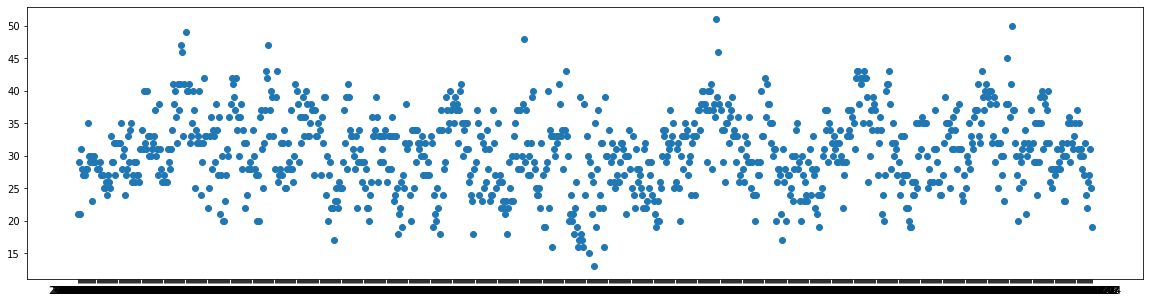

In [4]:
# show hrv data
plt.figure(figsize=(20,5))
df_plot = health_data_clean[health_data_clean['Average HRV'] < 60]
plt.scatter(df_plot.date, df_plot['Average HRV']);


In [5]:
# identification of missing values - 51 observations
missing_values = health_data_clean['Average HRV'].isnull().sum()

# missing values in percentage
missing_values / len(health_data_clean) * 100


4.990215264187866

In [6]:
# convert data types
# convert date to datetime object
health_data_clean.date = pd.to_datetime(health_data_clean.date, format = "%Y-%m-%d")

# convert Bedtime Start to datetime object
health_data_clean['Bedtime Start'] = pd.to_datetime(health_data_clean['Bedtime Start'], utc=True)
health_data_clean['Bedtime Start'] = health_data_clean['Bedtime Start'].dt.strftime('%H:%M')
health_data_clean['Bedtime Start']

# convert Bedtime End to datetime object
health_data_clean['Bedtime End'] = pd.to_datetime(health_data_clean['Bedtime End'], utc=True)
health_data_clean['Bedtime End'] = health_data_clean['Bedtime End'].dt.strftime('%H:%M')
health_data_clean['Bedtime End']


87        NaN
88      04:51
89      05:22
90      05:48
91        NaN
        ...  
1104    08:46
1105      NaN
1106    08:13
1107    08:36
1108    05:31
Name: Bedtime End, Length: 1022, dtype: object

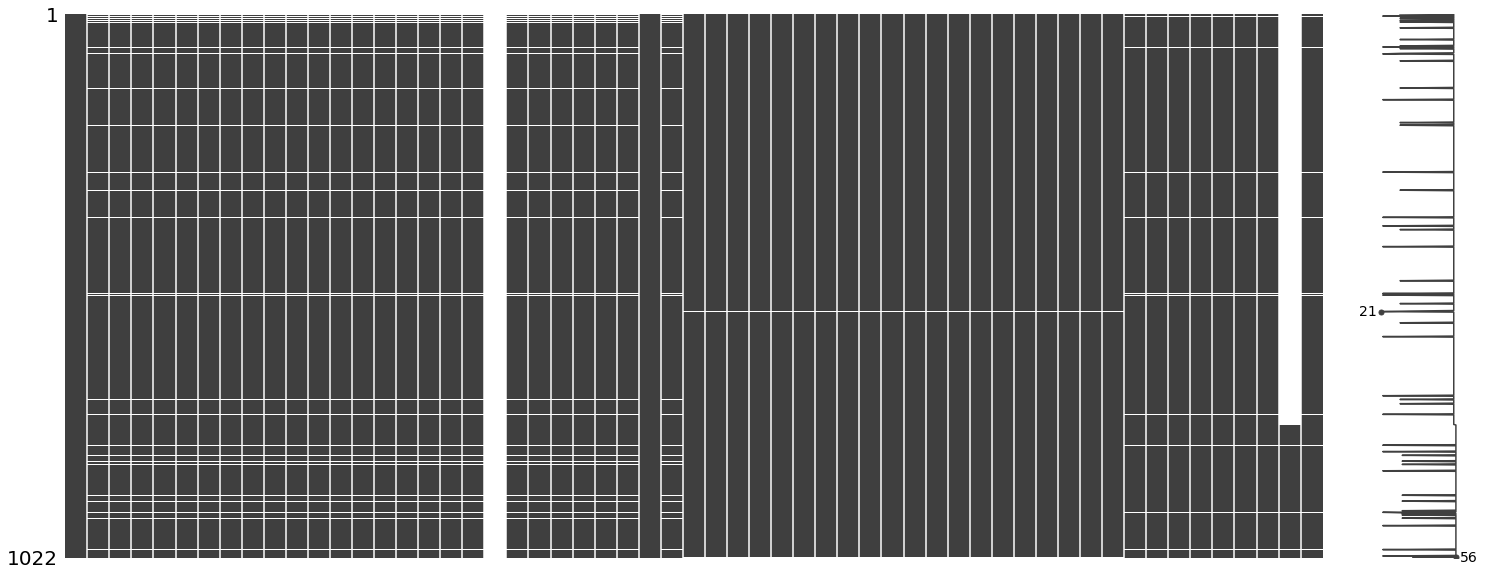

In [7]:
# innan
# make barcode plot
msno.matrix(health_data_clean);

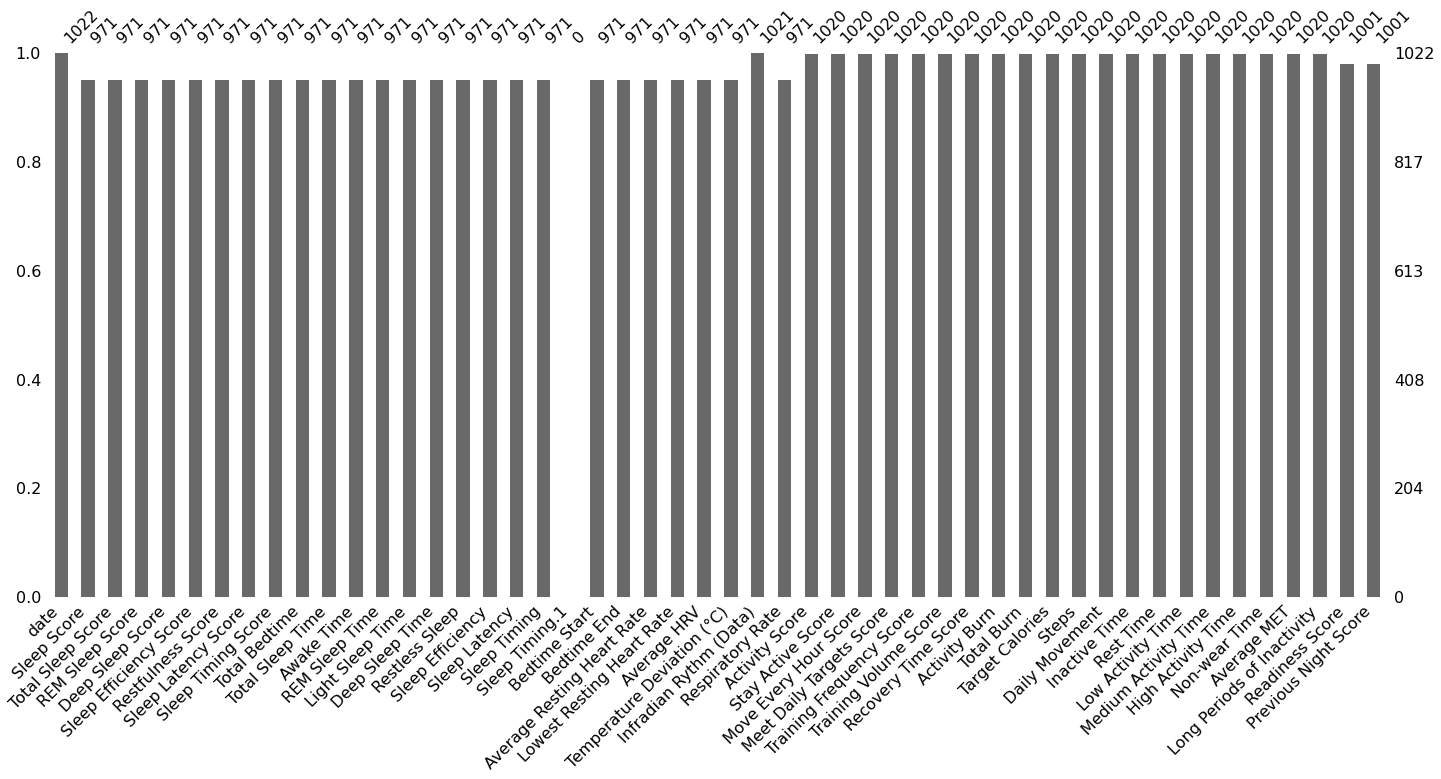

In [8]:
# innan 
# make bar plot
msno.bar(health_data_clean.iloc[:,:50]);

In [9]:
# dropping columns which has more than 90% data missing
nan_info = health_data_clean.isna().sum()
drop_cols = []
for n in range(len(nan_info)):
   if nan_info[n] > len(health_data)//10:
       drop_cols.append(nan_info.index[n])

health_data_clean = health_data_clean.drop(drop_cols, axis=1)


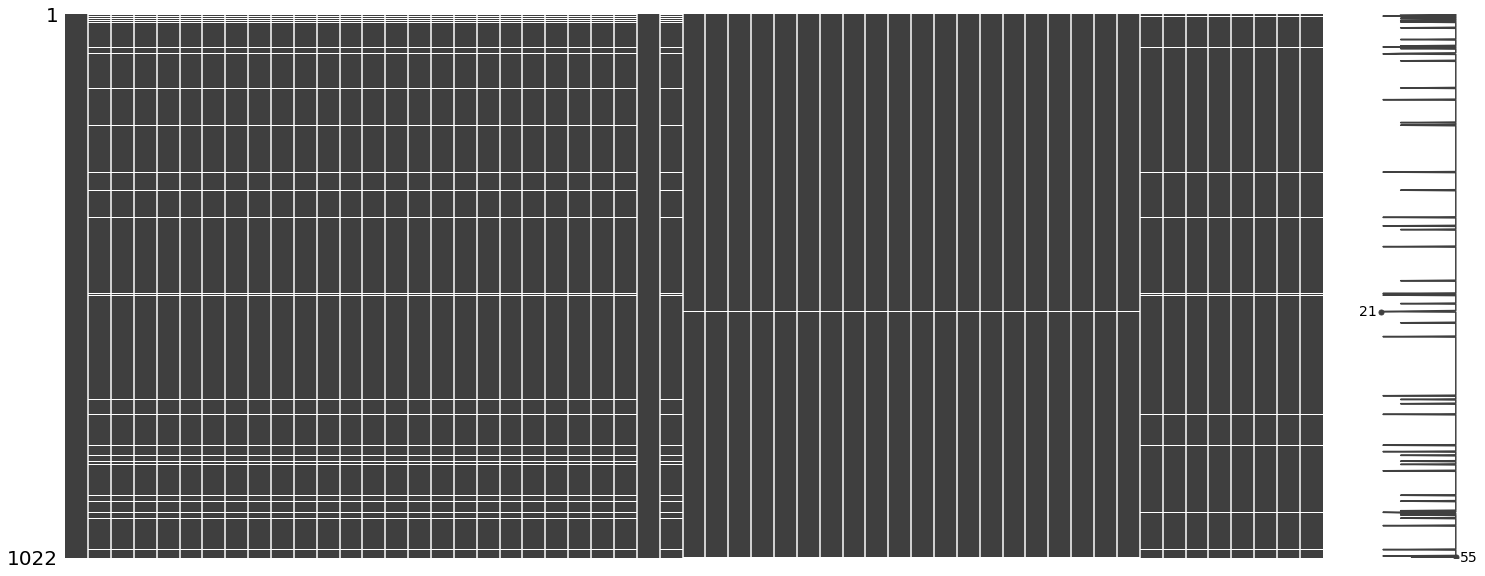

In [10]:
# innan
# make barcode plot
msno.matrix(health_data_clean);

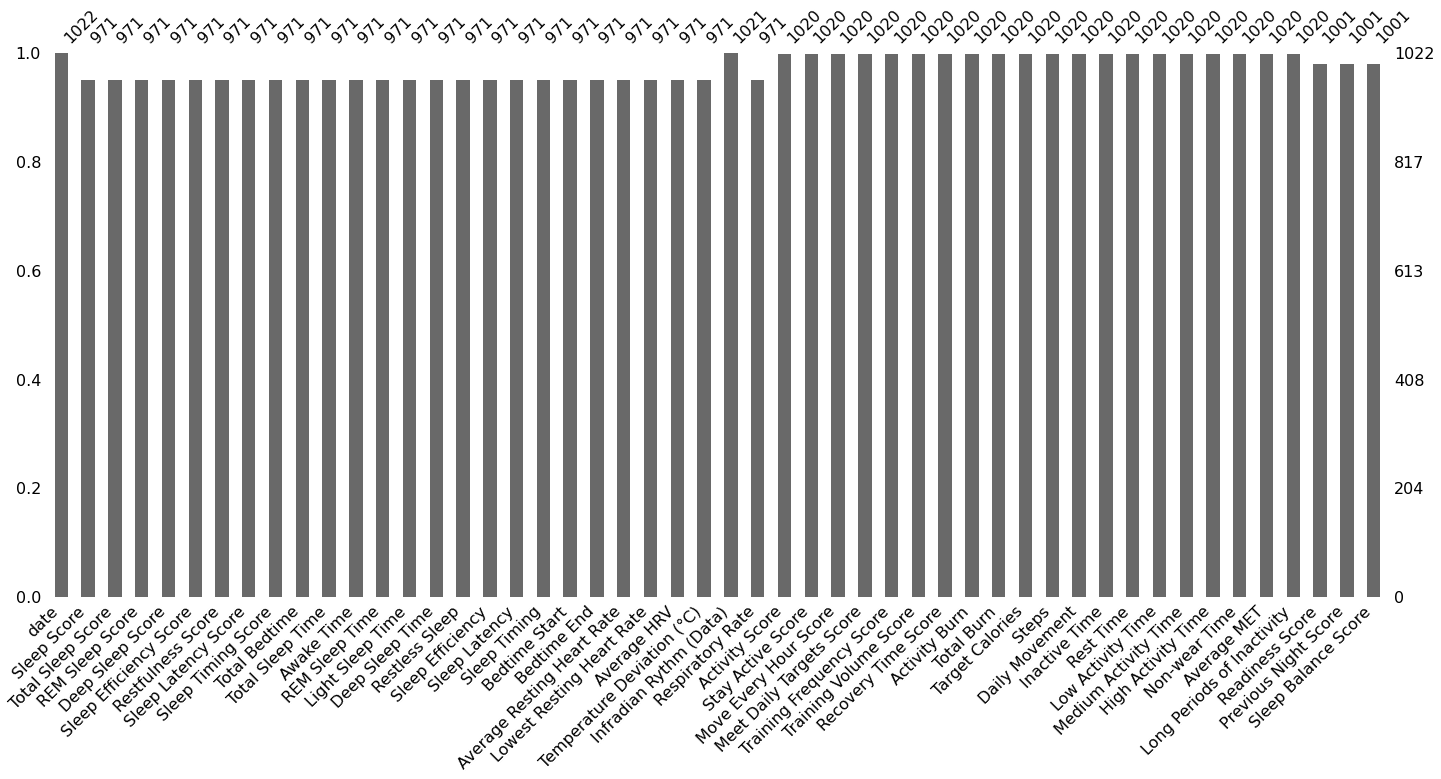

In [11]:
# innan 
# make bar plot
msno.bar(health_data_clean.iloc[:,:50]);

In [12]:
# large gaps in the data

# large missing values - weeks without ring
p1_start = '2019-07-14'
p1_end = '2019-07-30'
p2_start = pd.to_datetime('2020-09-04', format = "%Y-%m-%d") 
p2_end = pd.to_datetime('2020-10-05', format = "%Y-%m-%d")

# remove long period 1
mask = (health_data_clean.date < p1_start) | (health_data_clean.date > p1_end)
health_data_clean = health_data_clean[mask]

# remove long period 2
mask = (health_data_clean.date < p2_start) | (health_data_clean.date > p2_end)
health_data_clean = health_data_clean[mask]


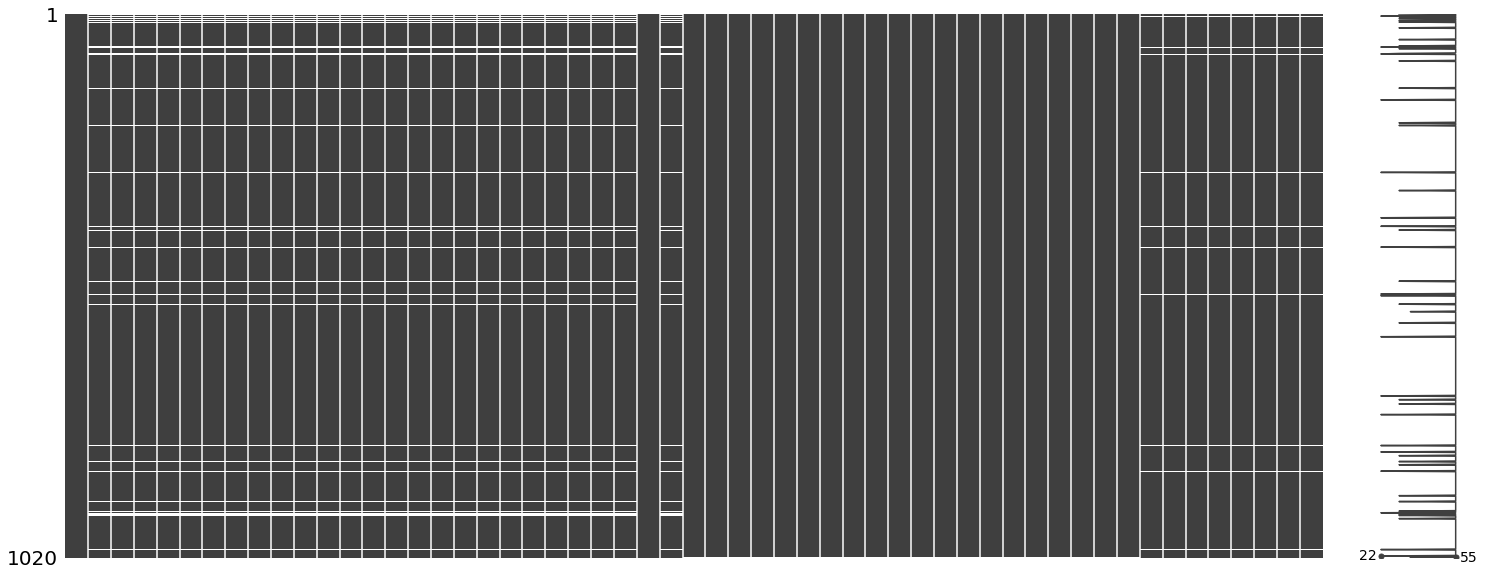

In [13]:
# after 
# make barcode plot
msno.matrix(health_data_clean);


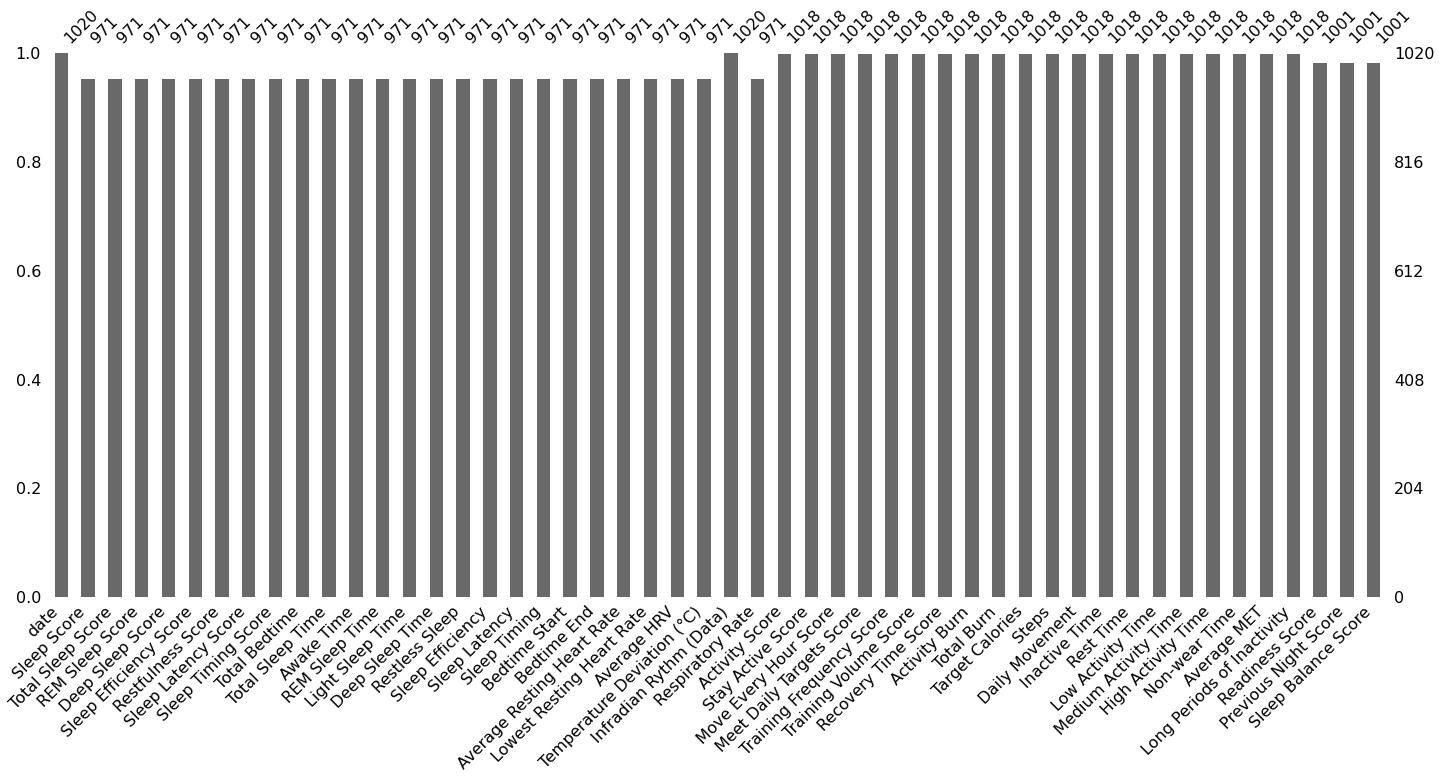

In [14]:
# after 
# make bar plot
msno.bar(health_data_clean.iloc[:,:50]);

In [15]:
# test
# fill null values - https://blockgeni.com/statistical-imputation-for-missing-values/

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
df_x = pd.DataFrame(X)
df_x.interpolate(method = 'linear', axis = 0, inplace = True)
df_x

,0,1,2
0,1.0,2,NaN
1,3.0,4,3.0
2,5.5,6,5.0
3,8.0,8,7.0


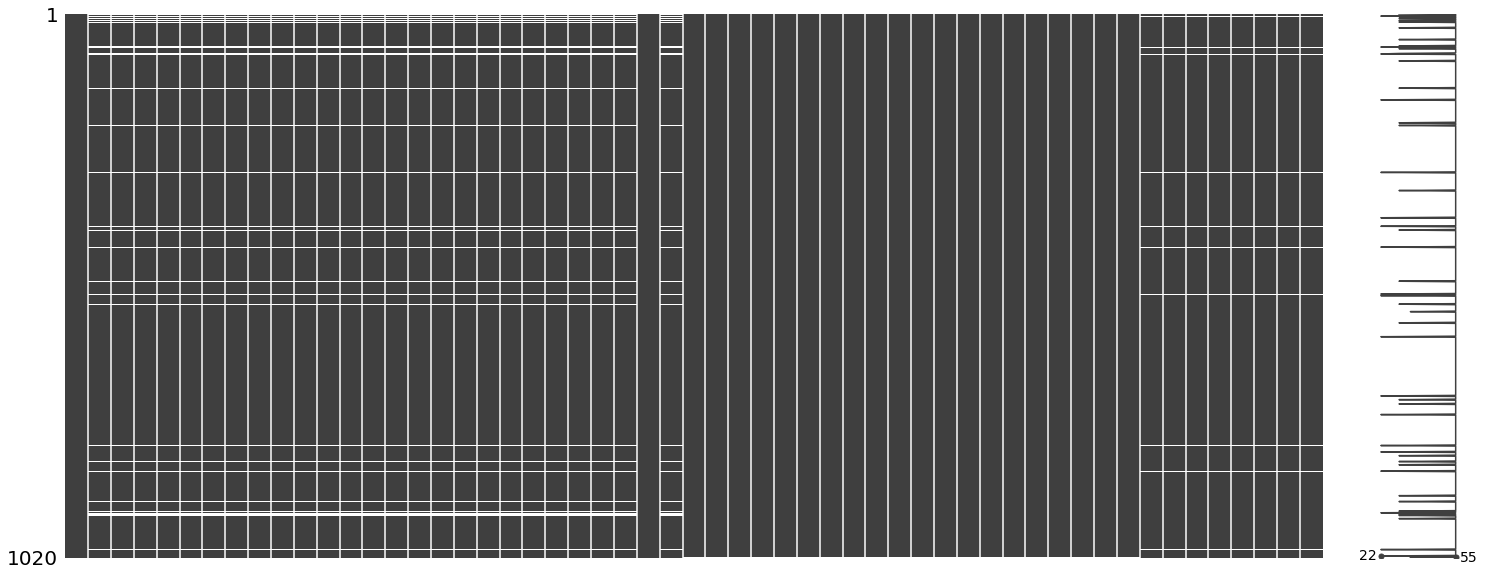

In [16]:
# after 
# make barcode plot
msno.matrix(health_data_clean);

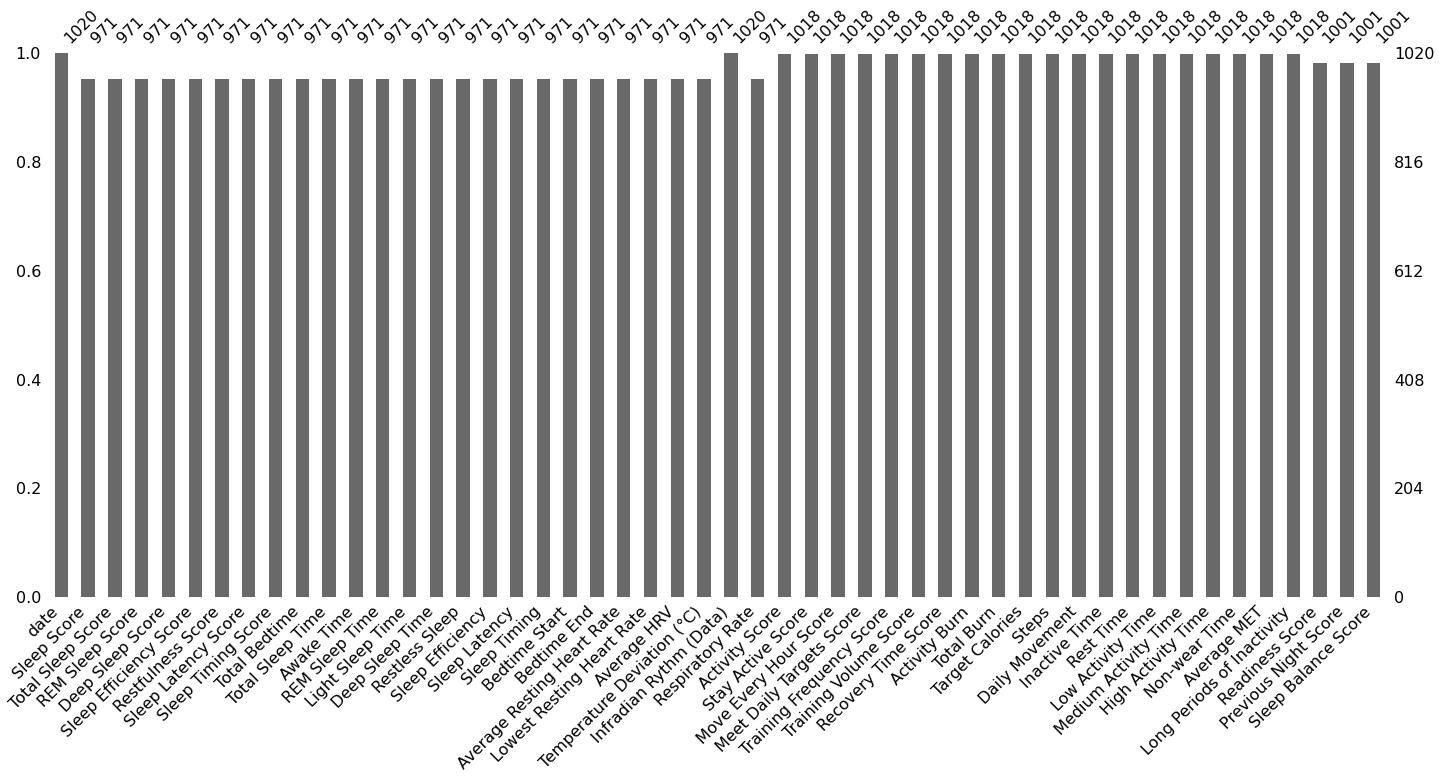

In [17]:
# after 
# make bar plot
msno.bar(health_data_clean.iloc[:,:50]);

In [18]:
# missing values - basic cleaning of data

# impute missing values - linear interpolation, chosen because data varies with time and we have full missing observations
health_data_clean.interpolate(method = 'linear', axis = 0, inplace = True)

# remove nulls 
health_data_clean = health_data_clean[health_data_clean['Bedtime Start'].notnull()]
health_data_clean = health_data_clean[health_data_clean['Bedtime End'].notnull()]

# remove invalid data 12 oct 2020 - What to do here? Should not remove.
# health_data_clean = health_data_clean[health_data_clean['date'] != '2020-10-12']

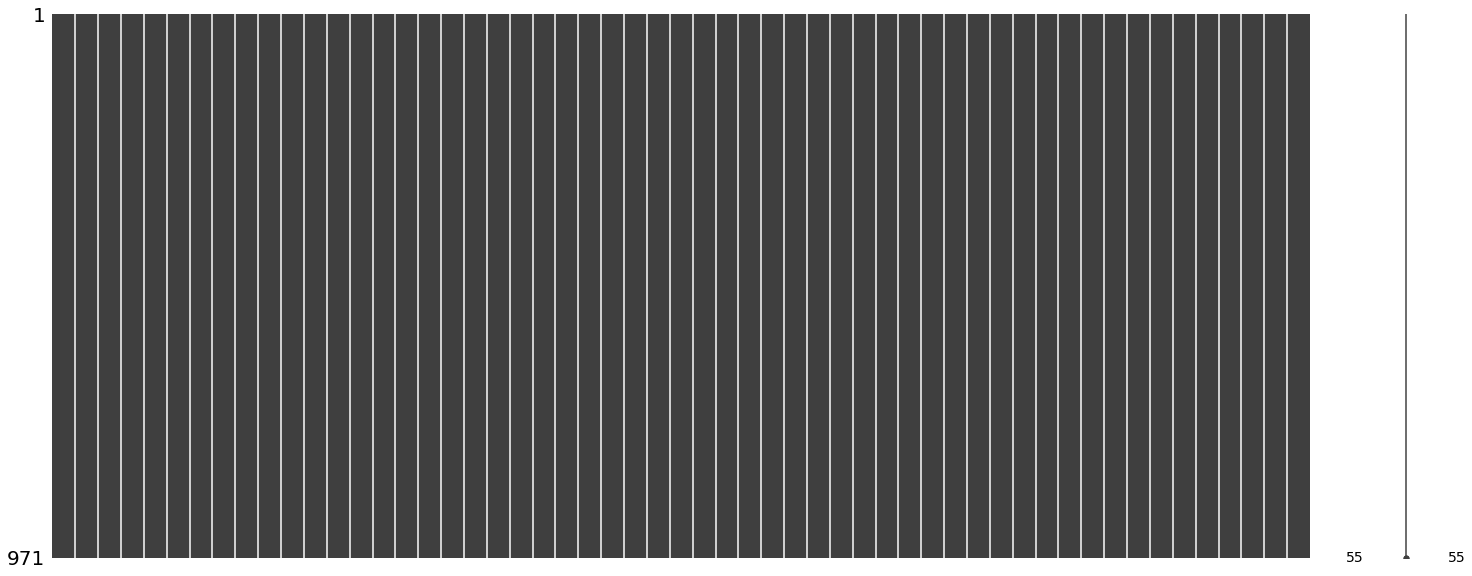

In [19]:
# after 
# make barcode plot
msno.matrix(health_data_clean);

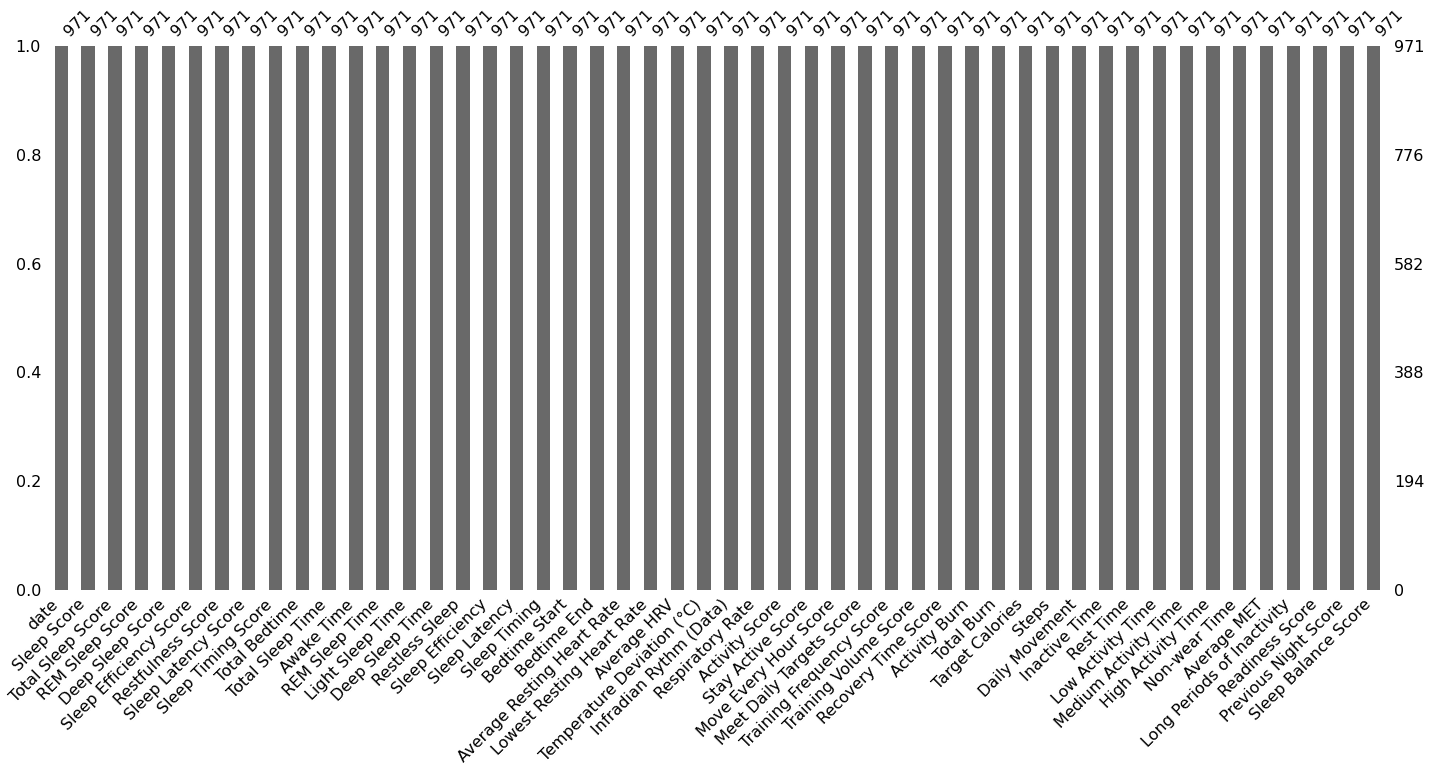

In [20]:
# after 
# make bar plot
msno.bar(health_data_clean.iloc[:,:50]);

In [21]:
# remove irrelevant factors - How do we know which ones are irrelevant? 
#health_data_clean = health_data_clean[['date', 'Readiness Score', 'Average Resting Heart Rate', 'Respiratory Rate', 'Average HRV', 'Deep Sleep Time', 'Recovery Index Score', 'Steps', 'Activity Score', 'Temperature Deviation (°C)', 'Infradian Rythm (Data)']]
#health_data_clean.info()

Text(0.5, 1.0, 'Data Distribution Seasons')

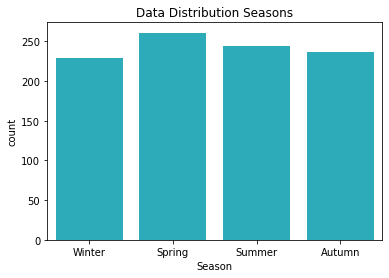

In [22]:
# create season column
# help red box

# pick months
# health_data_clean.date[1].month

health_data_clean.insert(1, 'Season', 'Null')

for i, row in enumerate(health_data_clean.date):
    # print('i = ', i)
    # print('row = ', row)
    # print('row month = ', row.month)
    # print('insert = ', health_data_clean.Season.iloc[i])
    health_data_clean.Season.iloc[i] = row.month
    
    if (row.month >= 12) or (row.month <= 2):
        health_data_clean.Season.iloc[i] = 'Winter'
    elif (row.month >= 3) and (row.month <= 5):
        health_data_clean.Season.iloc[i] = 'Spring'
    elif (row.month >= 6) and (row.month <= 8):
        health_data_clean.Season.iloc[i] = 'Summer' 
    else:
        health_data_clean.Season.iloc[i] = 'Autumn'

#print(i)
color = sb.color_palette()[9]
sb.countplot(health_data_clean.Season, color = color);
plt.title('Data Distribution Seasons')




In [23]:
# test
health_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 88 to 1108
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         971 non-null    datetime64[ns]
 1   Season                       971 non-null    object        
 2   Sleep Score                  971 non-null    float64       
 3   Total Sleep Score            971 non-null    float64       
 4   REM Sleep Score              971 non-null    float64       
 5   Deep Sleep Score             971 non-null    float64       
 6   Sleep Efficiency Score       971 non-null    float64       
 7   Restfulness Score            971 non-null    float64       
 8   Sleep Latency Score          971 non-null    float64       
 9   Sleep Timing Score           971 non-null    float64       
 10  Total Bedtime                971 non-null    float64       
 11  Total Sleep Time             971 non-null  

970


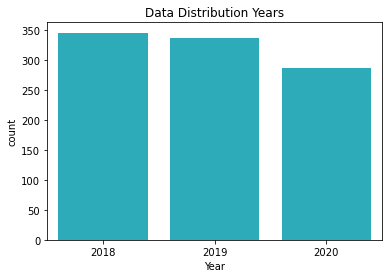

In [24]:
# create year column  
# help red box
# pick year

# health_data_clean.insert(1, 'Year', 'Null')
#i_list = []

#for i, row in enumerate(health_data_clean.date):
    #print('i = ', i)
    #print('row = ', row)
    # print('row month = ', row.month)
    # print('insert = ', health_data_clean.Season.iloc[i])
    #health_data_clean.Year.iloc[i] = row.year

health_data_clean['Year'] = health_data_clean.date.dt.year
# health_data_clean.info()
    
print(i)
color = sb.color_palette()[9]
sb.countplot(data = health_data_clean, x = 'Year', color = color);
plt.title('Data Distribution Years');


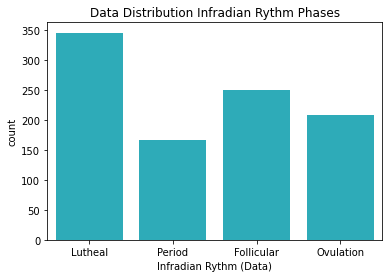

In [25]:
# Added for presentation
sb.countplot(data = health_data_clean, x = 'Infradian Rythm (Data)', color = color);
plt.title('Data Distribution Infradian Rythm Phases');



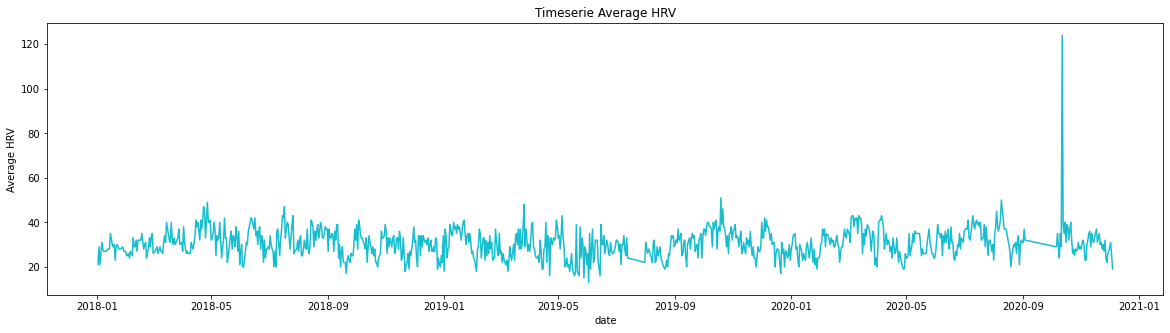

In [26]:
# Added for presentation ? 
plt.figure(figsize = (20,5))
sb.lineplot(data = health_data_clean, x = 'date', y = 'Average HRV', color = color);
plt.title('Timeserie Average HRV');


In [27]:
# Test
health_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 88 to 1108
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         971 non-null    datetime64[ns]
 1   Season                       971 non-null    object        
 2   Sleep Score                  971 non-null    float64       
 3   Total Sleep Score            971 non-null    float64       
 4   REM Sleep Score              971 non-null    float64       
 5   Deep Sleep Score             971 non-null    float64       
 6   Sleep Efficiency Score       971 non-null    float64       
 7   Restfulness Score            971 non-null    float64       
 8   Sleep Latency Score          971 non-null    float64       
 9   Sleep Timing Score           971 non-null    float64       
 10  Total Bedtime                971 non-null    float64       
 11  Total Sleep Time             971 non-null  

In [28]:
# Test
health_data_clean.head()

,date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year
88,2018-01-02,Winter,73.0,68.0,57.0,52.0,90.0,76.0,81.0,100.0,...,0.0,60.0,55.0,77.0,54.0,48.0,68.0,50.0,73.0,2018
89,2018-01-03,Winter,83.0,100.0,100.0,8.0,60.0,83.0,91.0,100.0,...,0.0,79.0,80.0,85.0,85.0,53.0,86.0,80.0,89.0,2018
90,2018-01-04,Winter,80.0,77.0,92.0,30.0,97.0,89.0,75.0,99.0,...,0.0,74.0,72.0,81.0,69.0,59.0,81.0,70.0,63.0,2018
92,2018-01-06,Winter,82.0,100.0,100.0,48.0,95.0,73.0,98.0,17.0,...,1.0,87.0,77.0,91.0,0.0,81.0,100.0,89.0,100.0,2018
93,2018-01-07,Winter,85.0,100.0,100.0,55.0,100.0,88.0,78.0,31.0,...,0.0,85.0,85.0,98.0,60.0,80.0,98.0,100.0,53.0,2018


In [29]:
# convert deep sleep unit to minutes
health_data_clean['Deep Sleep Time'] = health_data_clean['Deep Sleep Time']/60

In [30]:
# Test
health_data_clean.head()

,date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year
88,2018-01-02,Winter,73.0,68.0,57.0,52.0,90.0,76.0,81.0,100.0,...,0.0,60.0,55.0,77.0,54.0,48.0,68.0,50.0,73.0,2018
89,2018-01-03,Winter,83.0,100.0,100.0,8.0,60.0,83.0,91.0,100.0,...,0.0,79.0,80.0,85.0,85.0,53.0,86.0,80.0,89.0,2018
90,2018-01-04,Winter,80.0,77.0,92.0,30.0,97.0,89.0,75.0,99.0,...,0.0,74.0,72.0,81.0,69.0,59.0,81.0,70.0,63.0,2018
92,2018-01-06,Winter,82.0,100.0,100.0,48.0,95.0,73.0,98.0,17.0,...,1.0,87.0,77.0,91.0,0.0,81.0,100.0,89.0,100.0,2018
93,2018-01-07,Winter,85.0,100.0,100.0,55.0,100.0,88.0,78.0,31.0,...,0.0,85.0,85.0,98.0,60.0,80.0,98.0,100.0,53.0,2018


In [31]:
# estetics capitalize date column name
health_data_clean.rename(columns={"date": "Date"}, inplace = True) # help doesnt work


In [32]:
health_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 88 to 1108
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         971 non-null    datetime64[ns]
 1   Season                       971 non-null    object        
 2   Sleep Score                  971 non-null    float64       
 3   Total Sleep Score            971 non-null    float64       
 4   REM Sleep Score              971 non-null    float64       
 5   Deep Sleep Score             971 non-null    float64       
 6   Sleep Efficiency Score       971 non-null    float64       
 7   Restfulness Score            971 non-null    float64       
 8   Sleep Latency Score          971 non-null    float64       
 9   Sleep Timing Score           971 non-null    float64       
 10  Total Bedtime                971 non-null    float64       
 11  Total Sleep Time             971 non-null  

In [33]:
health_data_clean.to_csv('health-data-cleaned.csv', index=False)

### What is the structure of your dataset?

- The data contains 57 columns
- 1040 non null observations (3 years of data)
- Numeric data in 53 columns
- Categoric data in 4 columns
- The data is tidy and of high quality

### What is/are the main feature(s) of interest in your dataset?

- The main objective is to assess if and how overall health change with the infradian rythm, the menstrual cycle.
> _Would life style adaption to the infradian rythm would be benefital to overall health and performance?_


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

From my experience, I have chosen 12 variables presented in the data section to investigate further.

**Response variable**: Suggested response variables were; Readiness Score, RHR, Respiratory Rate, Temperature Deviation, HRV, Deep Sleep, Recovery Index Score. Finally, the Averate Heart Rate Variability was decided as the main response variable of interest, because it is a good indicator of mental and physical stress and have been showed to vary with phases of the infradian rytm ([1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6912442/), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4625231/?fbclid=IwAR0tXSuVWVqSSgVW9DwloIUorwI17qesgi_8euMSJprbuCh8Crm5oRkh57A)). This choise is further evaluated in the analysis. 

**Impact Factors**: Year, Season, Infradian Rythm Phases, Activity Score, Steps


## Univariate Exploration

> This section is divided into two parts:
> 1. Numerical Univariate Exploration
> 2. Categorical Bivariate Exploration

### Numeric Univariate Exploration

In [34]:
health_data_cleaned = pd.read_csv('health-data-cleaned.csv')
health_data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         971 non-null    object 
 1   Season                       971 non-null    object 
 2   Sleep Score                  971 non-null    float64
 3   Total Sleep Score            971 non-null    float64
 4   REM Sleep Score              971 non-null    float64
 5   Deep Sleep Score             971 non-null    float64
 6   Sleep Efficiency Score       971 non-null    float64
 7   Restfulness Score            971 non-null    float64
 8   Sleep Latency Score          971 non-null    float64
 9   Sleep Timing Score           971 non-null    float64
 10  Total Bedtime                971 non-null    float64
 11  Total Sleep Time             971 non-null    float64
 12  Awake Time                   971 non-null    float64
 13  REM Sleep Time      

In [35]:
# base color set
color = sb.color_palette()[9]
color_pal = sb.color_palette('tab10', n_colors=4)
color_pal_r = sb.color_palette('tab10', n_colors=4)

In [36]:
# Readiness Score outliers
health_data_cleaned[health_data_cleaned['Readiness Score'] == 35.0] # index 604 wedding can be excluded

# remove invalid data 12 oct 2020
health_data_cleaned = health_data_cleaned[health_data_cleaned['Readiness Score'] != 35.0]

health_data_cleaned[health_data_cleaned['Readiness Score'] == 35.0]

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year


In [37]:
# Deep Sleep outliers 
health_data_cleaned[health_data_cleaned['Deep Sleep Time'] <= 0.00] # hidden null values

# remove invalid data 12 oct 2020
health_data_cleaned = health_data_cleaned[health_data_cleaned['Deep Sleep Time'] != 0.00]

health_data_cleaned[health_data_cleaned['Deep Sleep Time'] <= 0.00]

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year


In [38]:
# Activity score outliers
health_data_cleaned[health_data_cleaned['Recovery Index Score'] <= 00.00] # hidden null values

# remove invalid data 12 oct 2020
health_data_cleaned = health_data_cleaned[health_data_cleaned['Activity Score'] != 0.00]

health_data_cleaned[health_data_cleaned['Activity Score'] <= 00.00]

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year


In [39]:
# Recovery outliers
health_data_cleaned[health_data_cleaned['Recovery Index Score'] <= 5.00] # can exclude one value where no data existing

# remove invalid data 12 oct 2020
health_data_cleaned = health_data_cleaned[health_data_cleaned['Date'] != '2017-11-14'] # no data collected 

# test
health_data_cleaned[health_data_cleaned['Recovery Index Score'] <= 5.00] 

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year
84,2018-04-08,Spring,90.0,100.0,97.0,57.0,99.0,79.0,78.0,98.0,...,0.0,82.0,96.0,95.0,82.0,100.0,92.0,84.0,4.0,2018
86,2018-04-10,Spring,89.0,81.0,98.0,81.0,96.0,88.0,98.0,100.0,...,2.0,79.0,94.0,74.0,65.0,100.0,94.0,100.0,2.0,2018
131,2018-05-26,Spring,91.0,100.0,100.0,62.0,97.0,82.0,81.0,100.0,...,0.0,84.0,99.0,90.0,83.0,84.0,87.0,100.0,2.0,2018


In [40]:
# Temp outliers
health_data_cleaned[health_data_cleaned['Temperature Deviation (°C)'] >= 1] # > 1 sick ok to exclude? (all in Lutheal)

# remove invalid data 12 oct 2020
health_data_cleaned = health_data_cleaned[health_data_cleaned['Temperature Deviation (°C)'] <= 1]

health_data_cleaned[health_data_cleaned['Temperature Deviation (°C)'] >= 1]

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year


In [41]:
# Temp outliers - it ok no need to remove
health_data_cleaned[health_data_cleaned['Temperature Deviation (°C)'] <= -0.6] # > 1 sick ok to exclude? (all in Lutheal)

# remove invalid data 12 oct 2020
#health_data_clean = health_data_clean[health_data_clean['Temperature Deviation (°C)'] <= 1]

#health_data_clean[health_data_clean['Temperature Deviation (°C)'] >= 1]

,Date,Season,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,...,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score,Year
895,2020-08-16,Summer,77.0,77.0,97.0,9.0,100.0,87.0,94.0,74.0,...,1.0,69.0,65.0,59.0,100.0,77.0,80.0,40.0,69.0,2020
919,2020-10-12,Autumn,77.0,79.0,50.0,99.0,83.0,61.0,72.0,94.0,...,2.0,73.0,65.0,70.0,80.0,51.0,79.0,52.0,100.0,2020


In [42]:
# create sub df with numeric dtypes
health_data_cleaned_num = health_data_cleaned.select_dtypes(include = 'float64')
health_data_cleaned_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 970
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sleep Score                  958 non-null    float64
 1   Total Sleep Score            958 non-null    float64
 2   REM Sleep Score              958 non-null    float64
 3   Deep Sleep Score             958 non-null    float64
 4   Sleep Efficiency Score       958 non-null    float64
 5   Restfulness Score            958 non-null    float64
 6   Sleep Latency Score          958 non-null    float64
 7   Sleep Timing Score           958 non-null    float64
 8   Total Bedtime                958 non-null    float64
 9   Total Sleep Time             958 non-null    float64
 10  Awake Time                   958 non-null    float64
 11  REM Sleep Time               958 non-null    float64
 12  Light Sleep Time             958 non-null    float64
 13  Deep Sleep Time     

In [43]:
health_data_cleaned_num.describe()

,Sleep Score,Total Sleep Score,REM Sleep Score,Deep Sleep Score,Sleep Efficiency Score,Restfulness Score,Sleep Latency Score,Sleep Timing Score,Total Bedtime,Total Sleep Time,...,Average MET,Long Periods of Inactivity,Readiness Score,Previous Night Score,Sleep Balance Score,Previous Day Activity Score,Activity Balance Score,Temperature Score,Resting Heart Rate Score,Recovery Index Score
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,...,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,85.740084,92.245303,97.085595,48.029228,94.956159,88.747390,83.634656,77.550104,34136.743215,31318.810021,...,1.325858,0.559499,81.626305,83.621086,84.639875,72.763048,81.324635,92.949896,79.686848,78.921712
std,5.408716,8.744328,8.061349,20.554924,9.425402,6.641347,12.446757,25.519986,4859.504668,3770.637319,...,0.108292,0.769120,8.098803,13.044152,13.674174,25.931128,12.478949,9.852920,22.520861,24.912661
min,52.000000,38.000000,19.000000,1.000000,23.000000,61.000000,1.000000,4.000000,21120.000000,16290.000000,...,0.937500,0.000000,43.000000,2.000000,0.000000,0.000000,0.000000,48.000000,1.000000,2.000000
25%,83.000000,87.000000,98.000000,32.000000,95.000000,85.000000,79.000000,60.000000,30960.000000,28920.000000,...,1.281250,0.000000,77.000000,78.000000,76.000000,65.250000,74.000000,89.000000,69.250000,57.250000
50%,87.000000,95.000000,100.000000,46.000000,99.000000,90.000000,84.000000,87.000000,33060.000000,30720.000000,...,1.343750,0.000000,83.000000,86.000000,86.000000,79.000000,83.000000,98.000000,88.000000,93.000000
75%,89.000000,100.000000,100.000000,61.000000,100.000000,94.000000,90.000000,100.000000,36600.000000,33420.000000,...,1.406250,1.000000,87.000000,93.000000,96.000000,90.000000,90.000000,100.000000,98.000000,100.000000
max,97.000000,100.000000,100.000000,99.000000,100.000000,98.000000,99.000000,100.000000,54000.000000,47280.000000,...,1.687500,5.000000,98.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


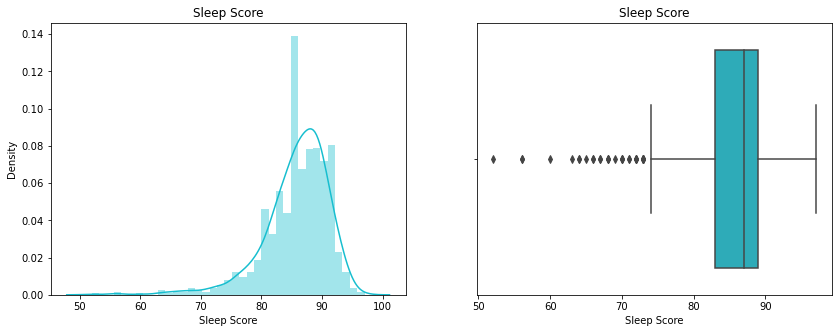

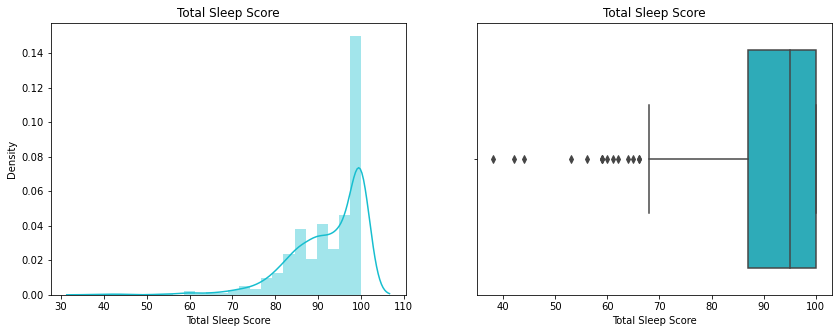

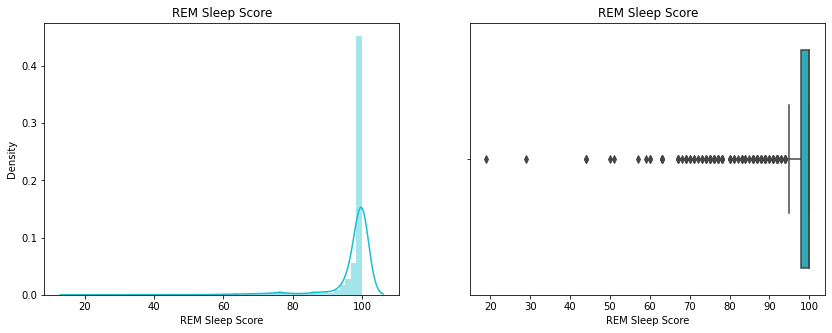

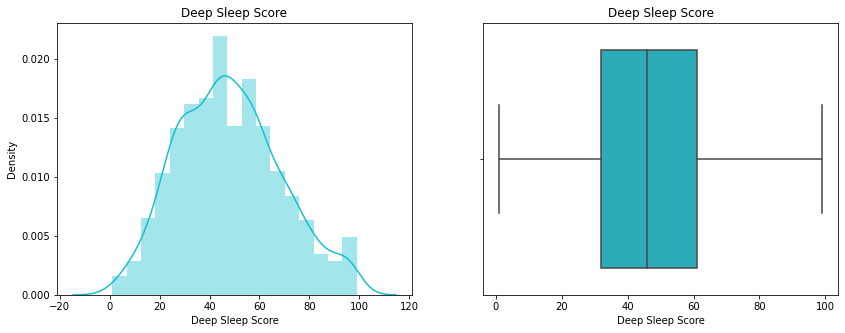

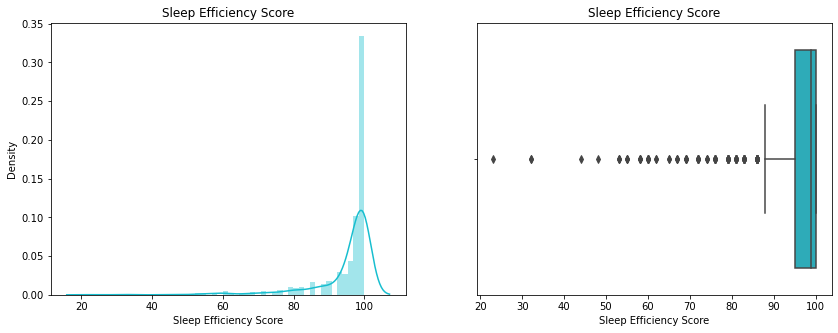

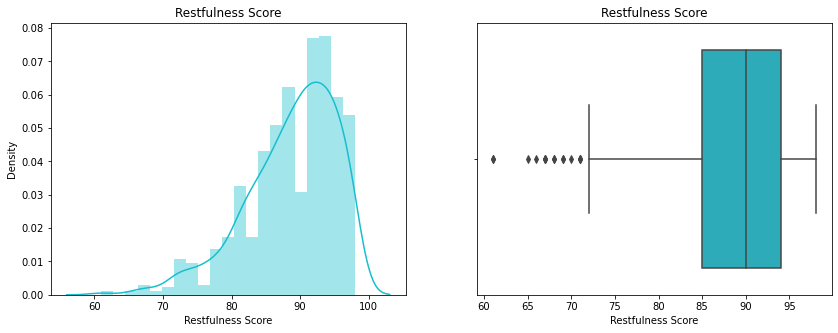

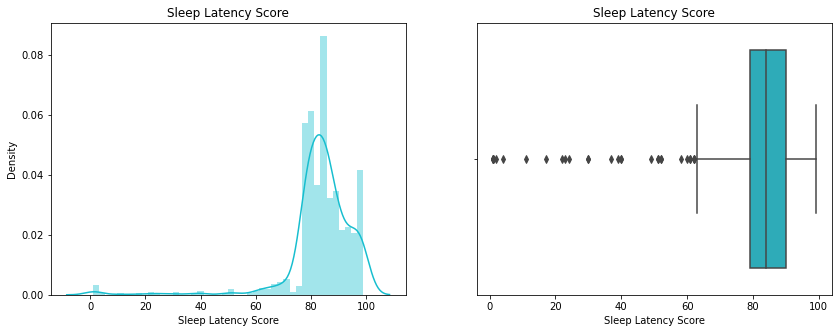

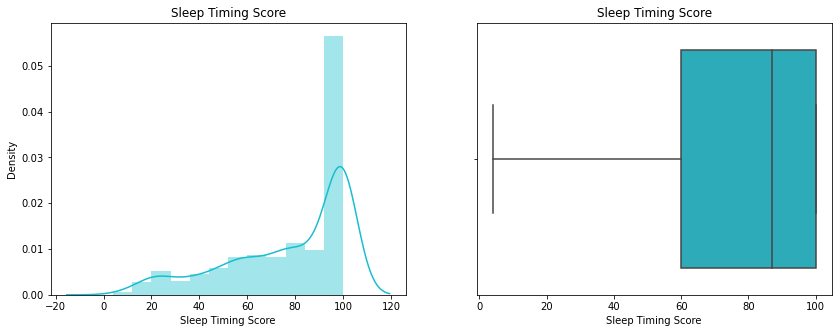

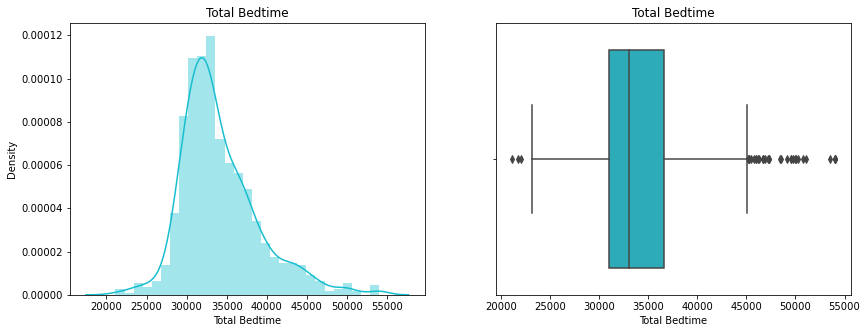

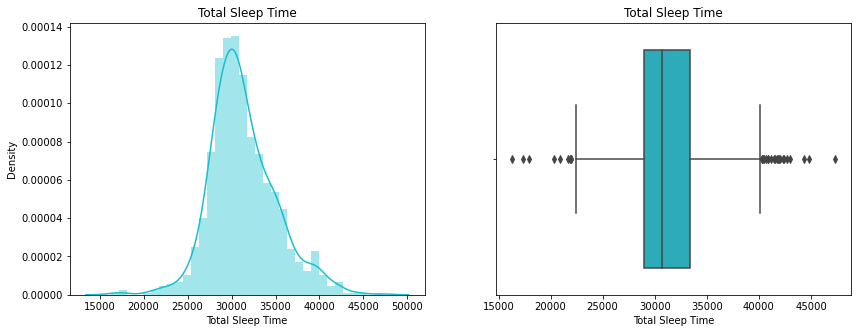

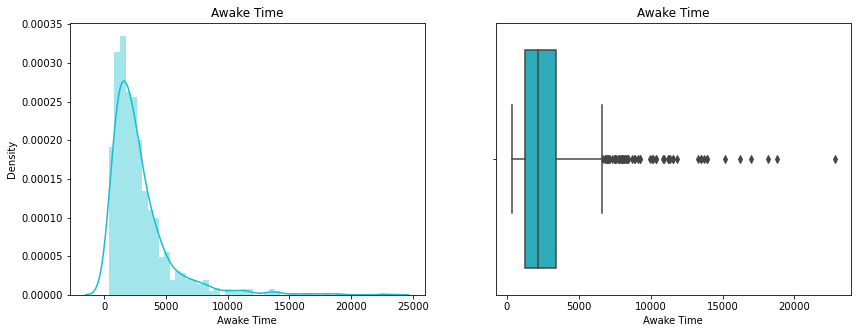

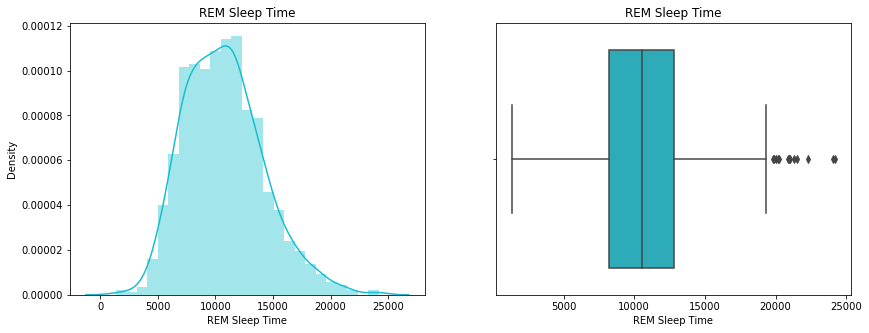

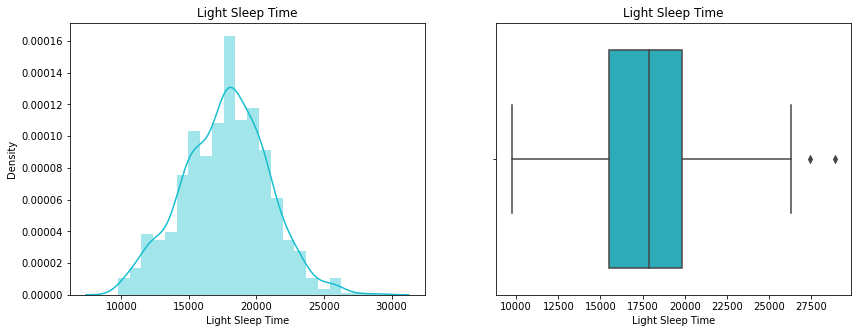

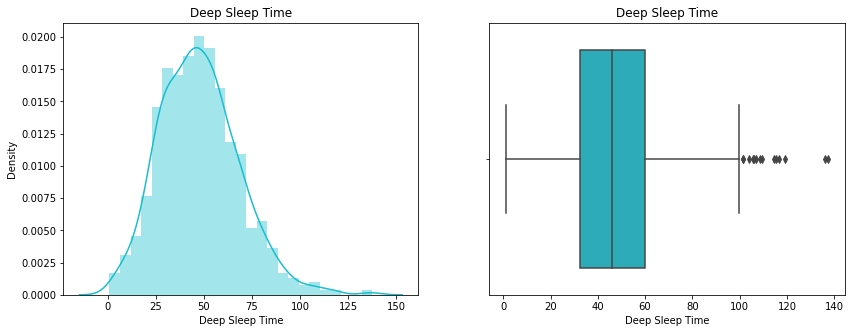

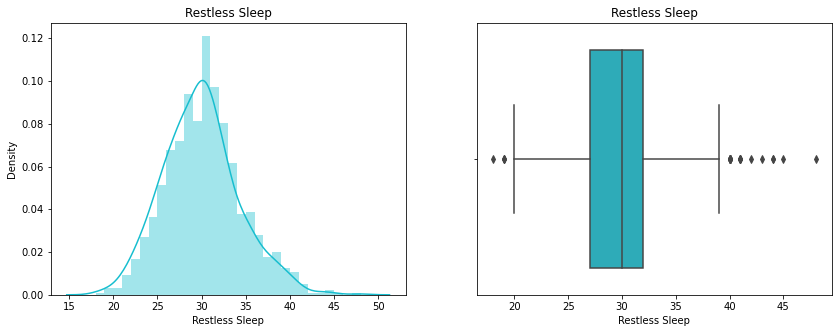

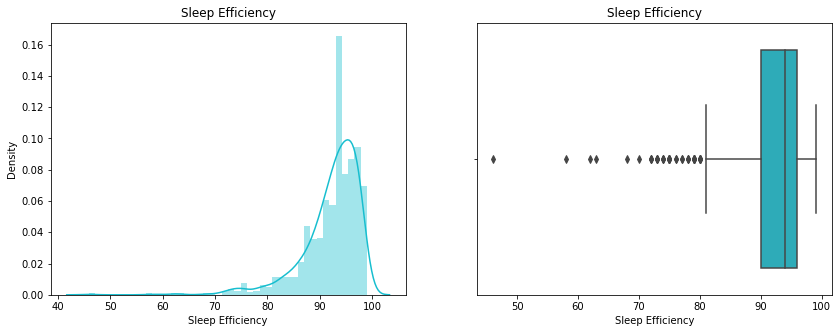

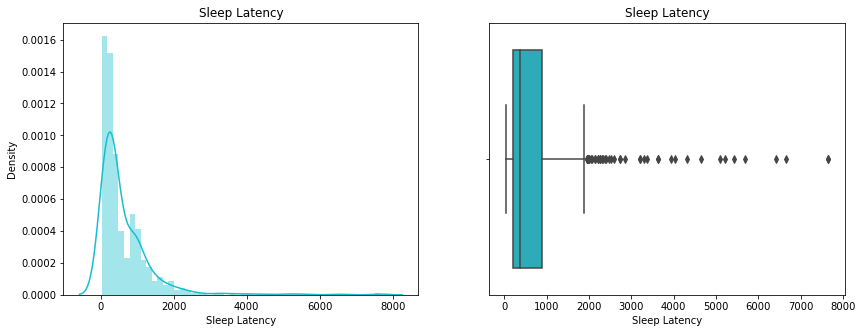

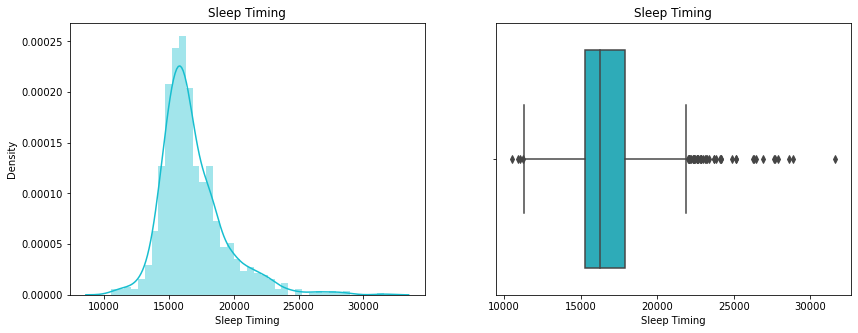

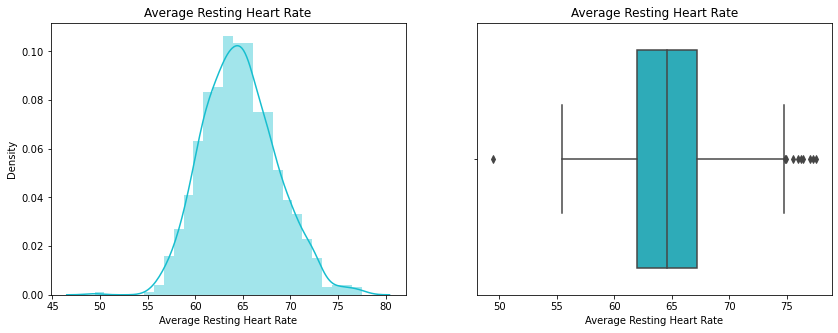

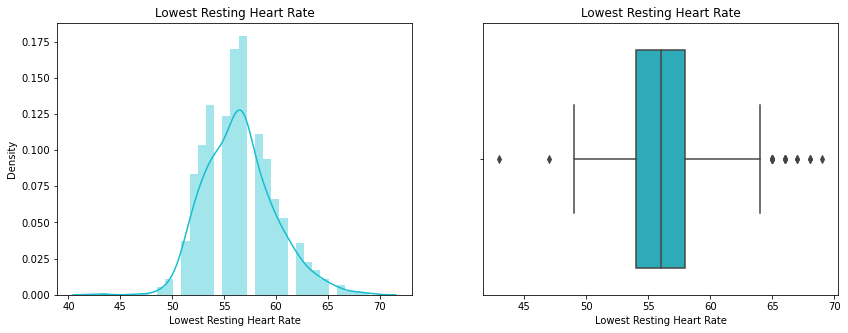

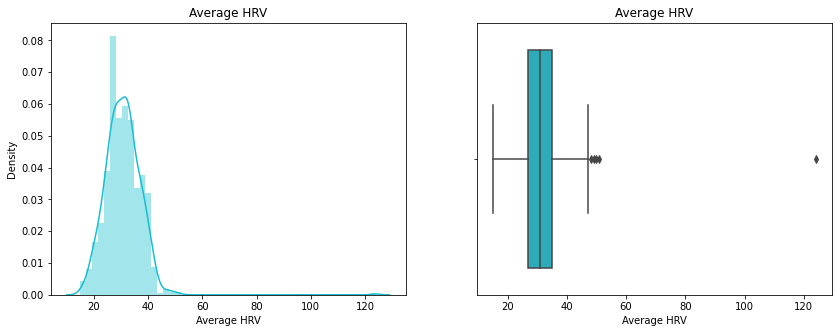

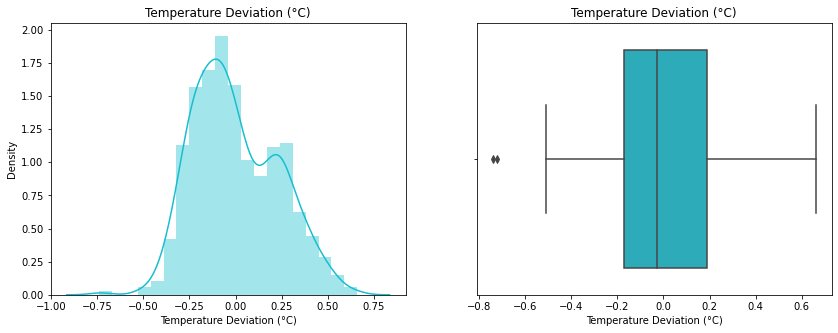

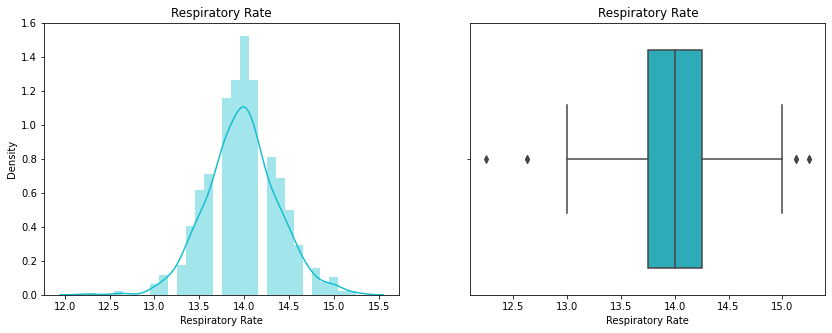

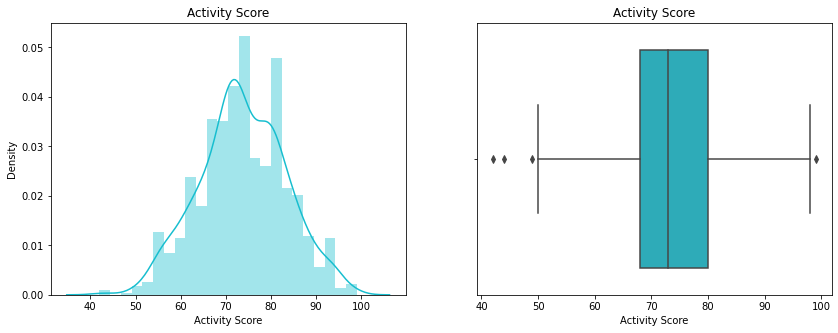

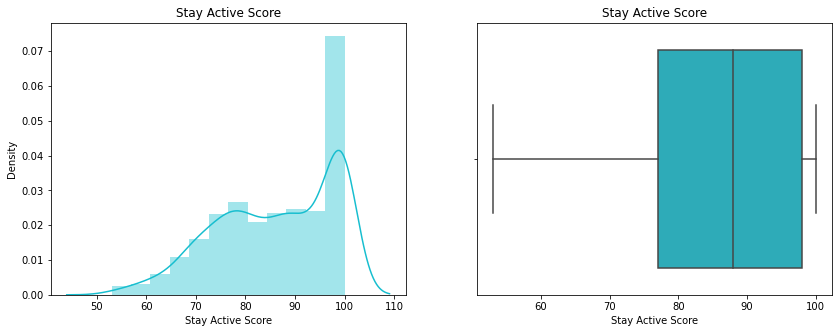

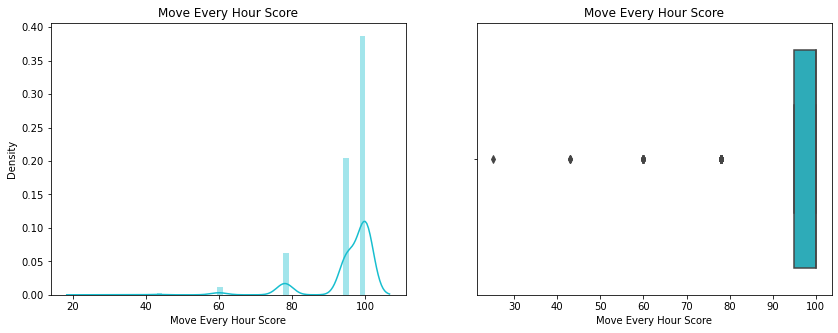

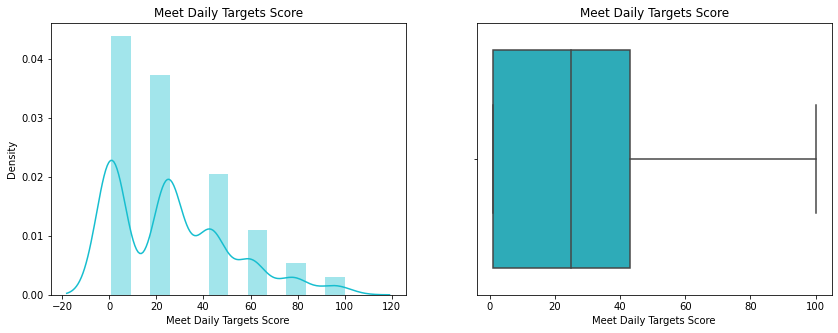

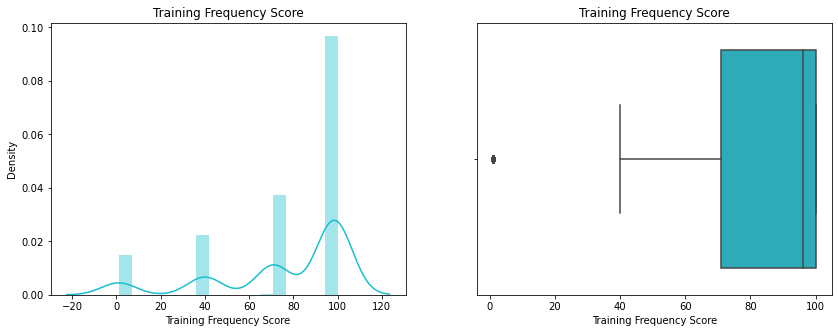

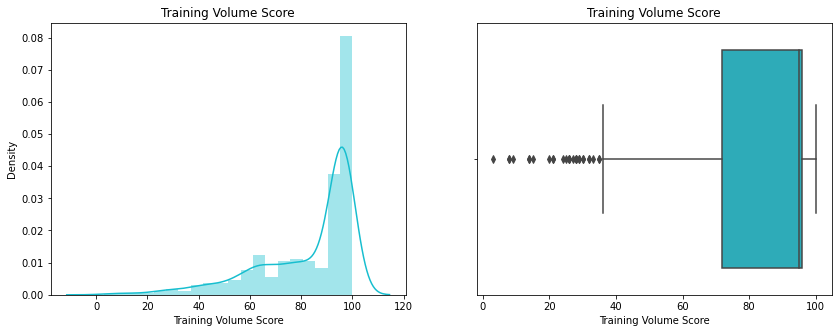

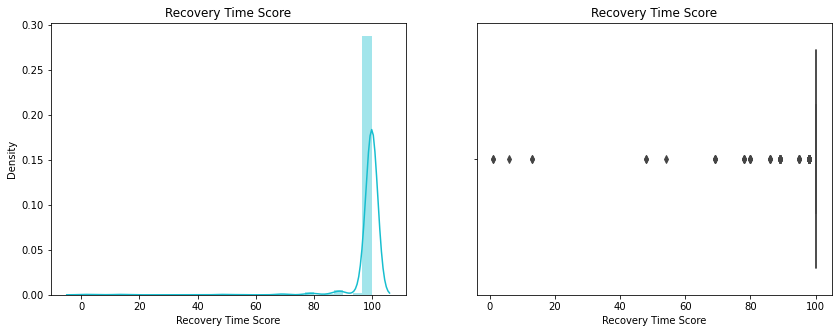

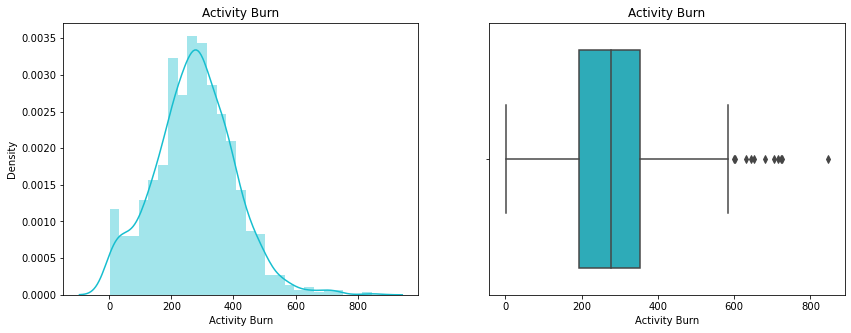

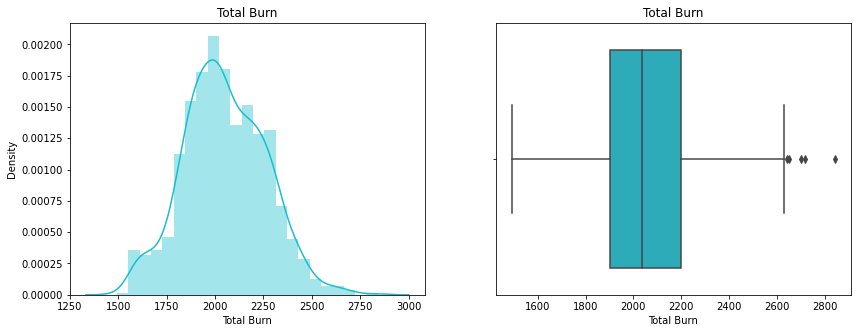

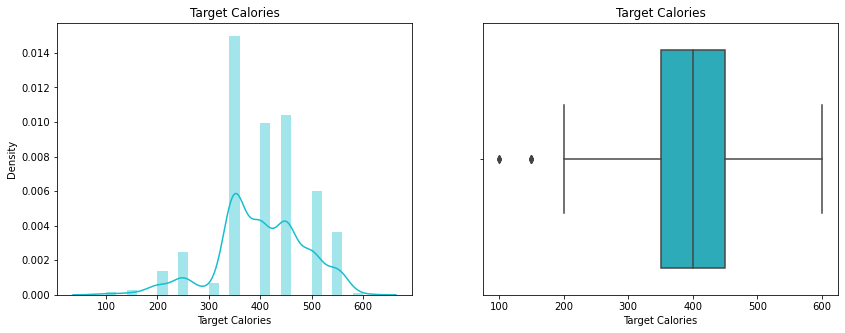

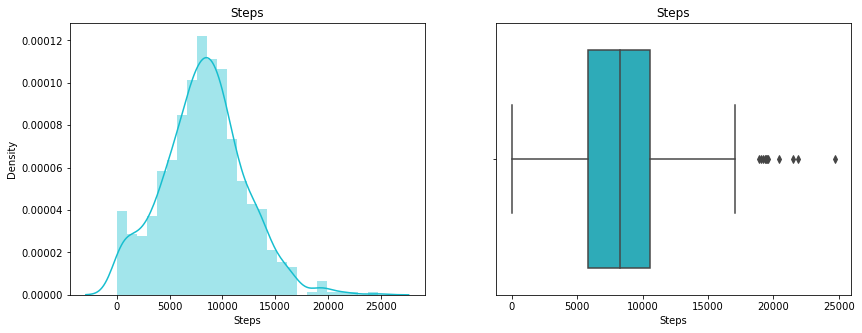

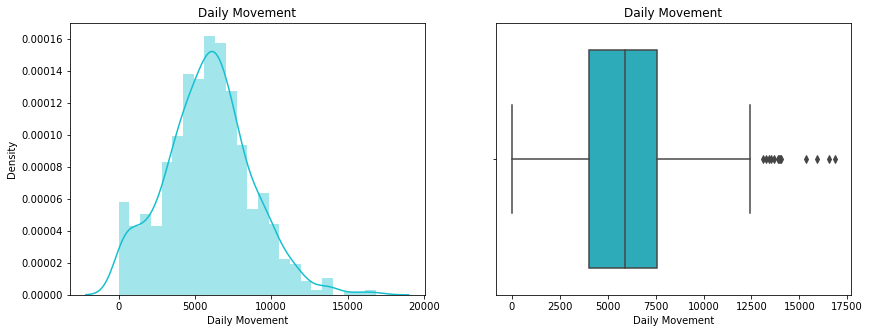

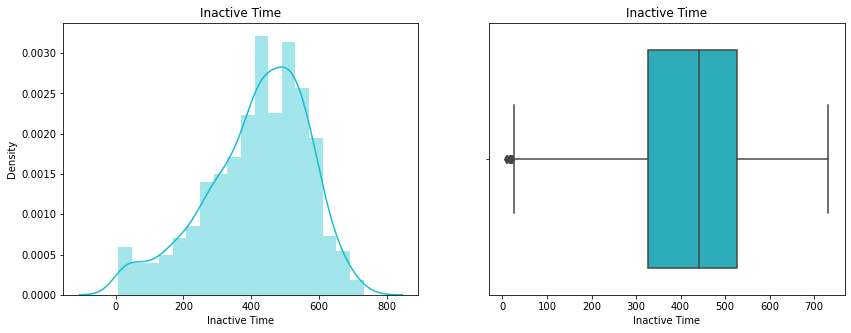

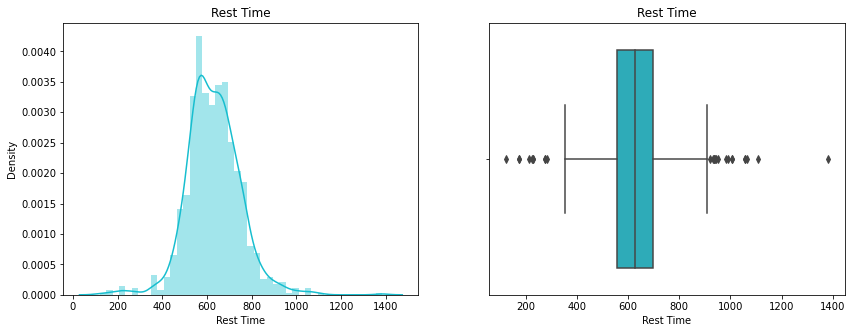

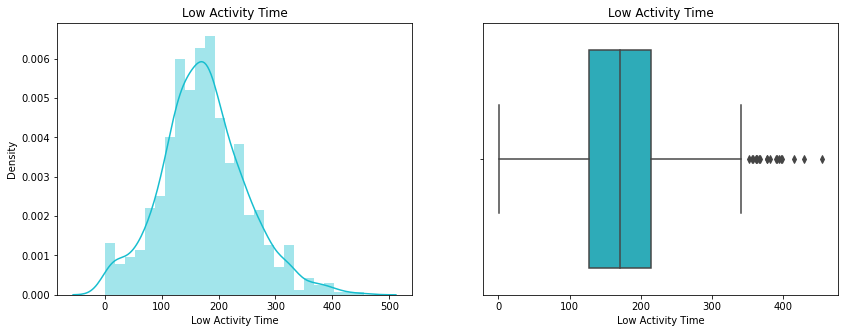

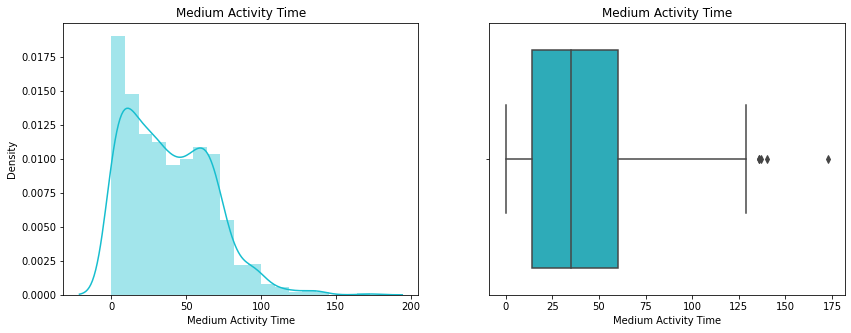

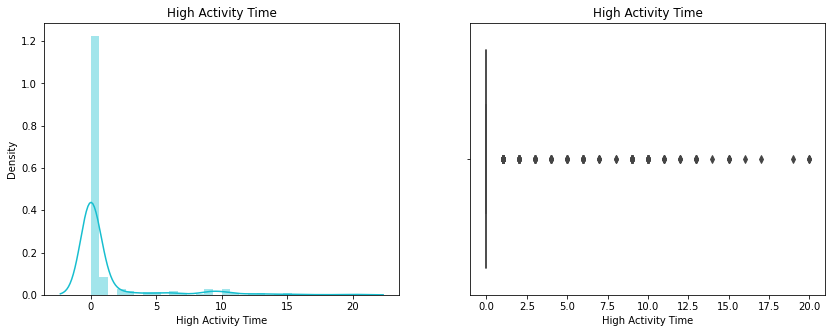

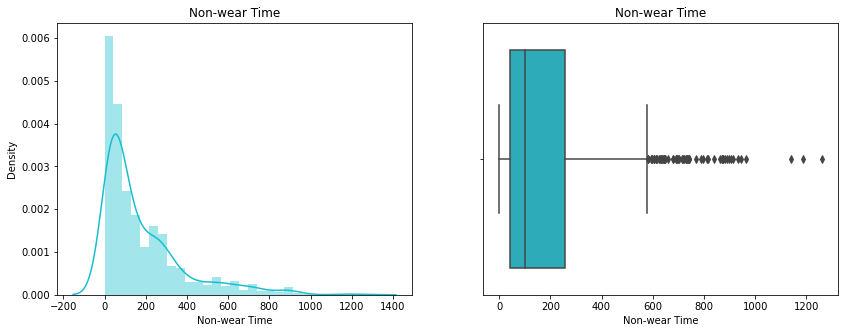

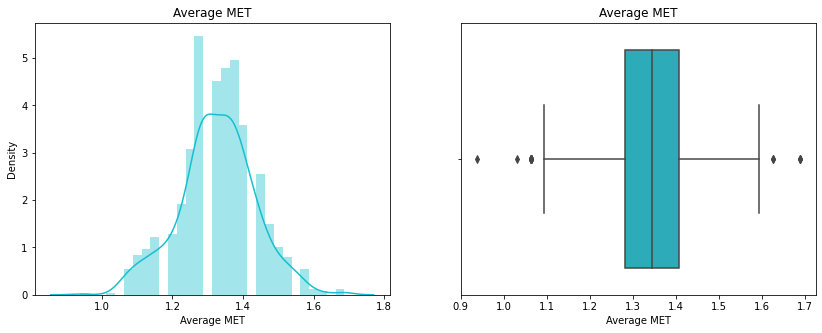

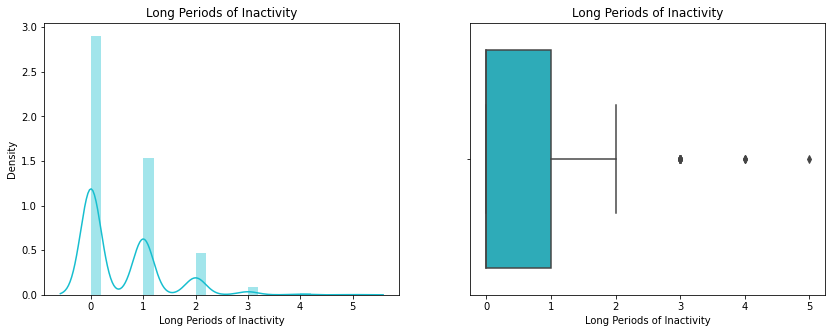

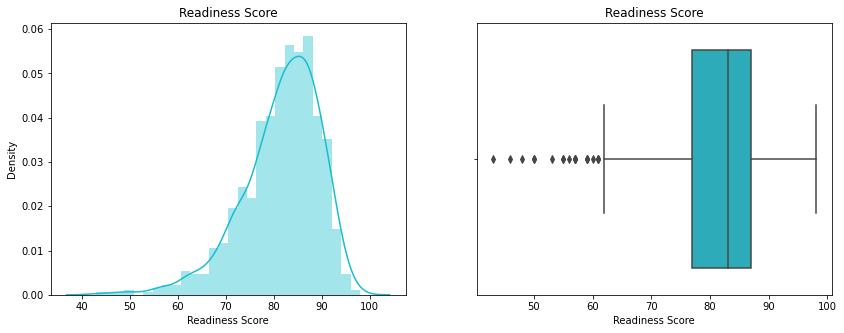

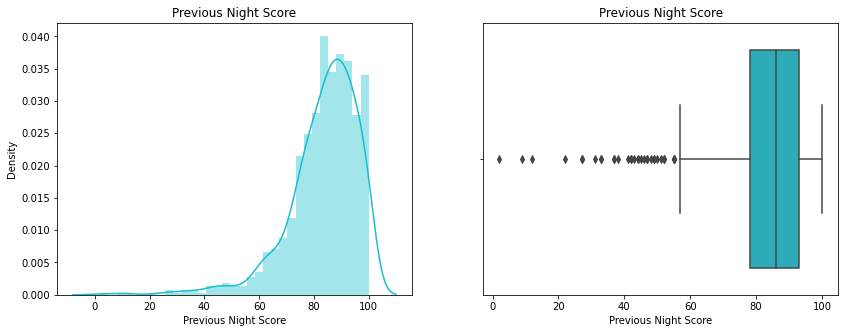

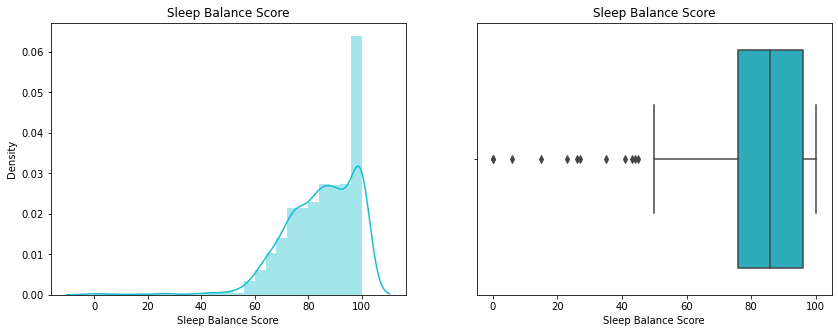

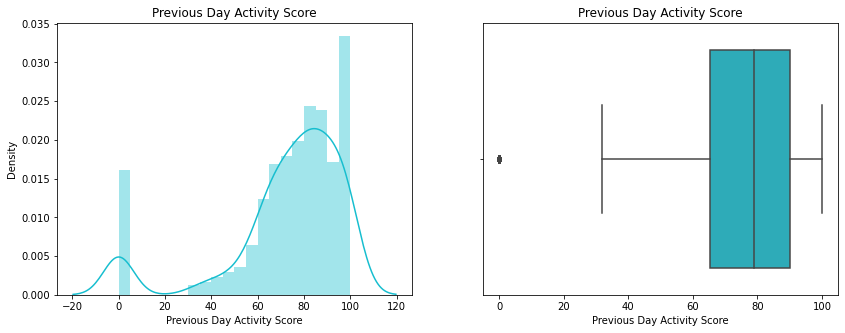

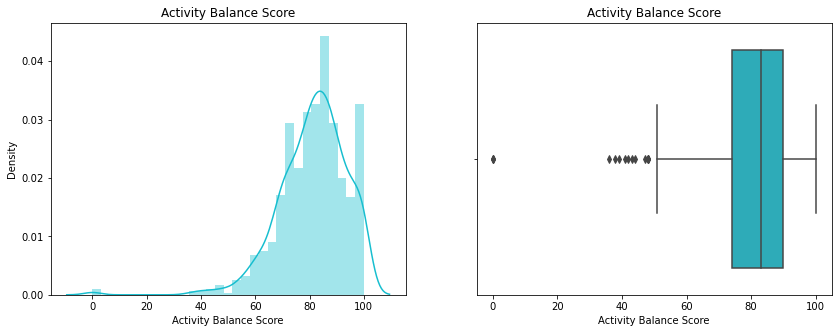

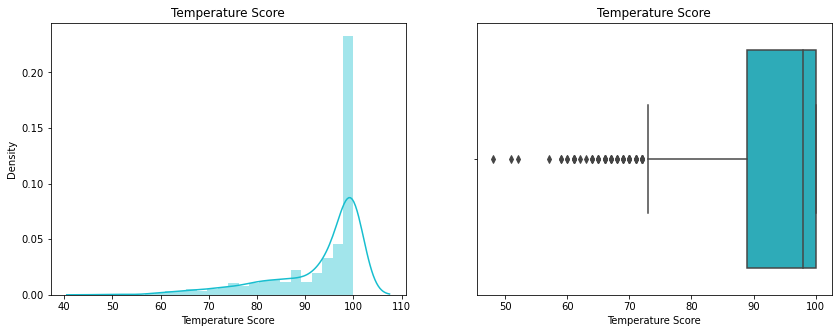

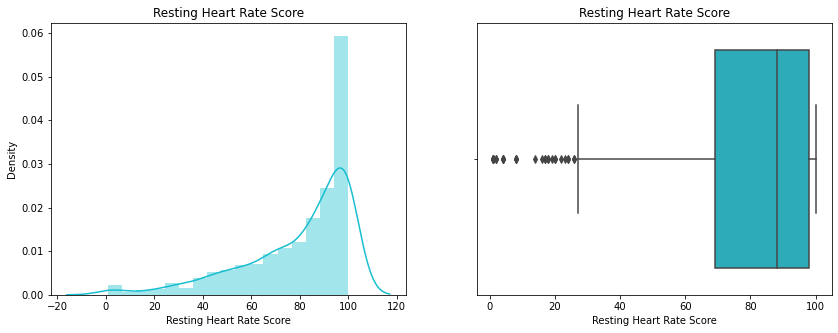

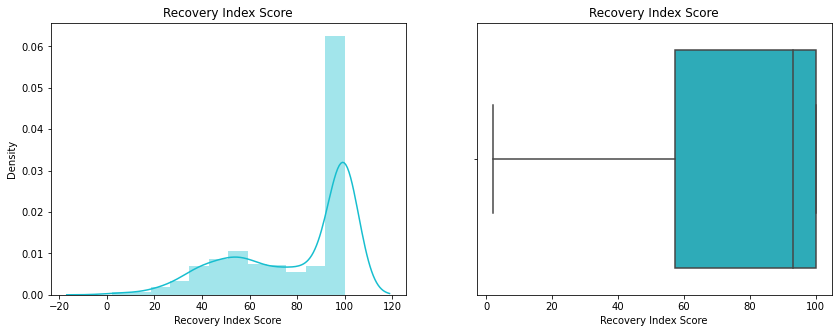

In [44]:
### Frequency Distributions

for col in health_data_cleaned_num:
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    # sb.histplot(data = health_data_cleaned_num, x = col, kde = True, edgecolor = "none", alpha = 0.3, color = color)
    sb.distplot(health_data_cleaned_num[col], kde = True, color = color)
    plt.title(col)
    
    plt.subplot(1,2,2)
    sb.boxplot(data = health_data_cleaned_num, x = col, color = color)
    plt.title(col)
    plt.show()

plt.show()
    
   

In [45]:
# skewness - 
print(health_data_cleaned_num.agg(['skew']).transpose())

# interpretation
# Fairly Symmetrical -0.5 to 0.5
# Moderate Skewed -0.5 to -1.0 and 0.5 to 1.0
# Highly Skewed < -1.0 and > 1.0




                                 skew
Sleep Score                 -1.618818
Total Sleep Score           -1.645655
REM Sleep Score             -4.416801
Deep Sleep Score             0.282879
Sleep Efficiency Score      -3.215279
Restfulness Score           -0.958800
Sleep Latency Score         -3.484736
Sleep Timing Score          -0.950234
Total Bedtime                1.097089
Total Sleep Time             0.472432
Awake Time                   2.930920
REM Sleep Time               0.543635
Light Sleep Time            -0.004535
Deep Sleep Time              0.542804
Restless Sleep               0.367564
Sleep Efficiency            -2.257515
Sleep Latency                4.051089
Sleep Timing                 1.472698
Average Resting Heart Rate   0.280745
Lowest Resting Heart Rate    0.440219
Average HRV                  2.904334
Temperature Deviation (°C)   0.350222
Respiratory Rate             0.038144
Activity Score              -0.053666
Stay Active Score           -0.475010
Move Every H

### Univariate findings

**Readyness Score**:
The distribution is moderate left skewed (skew -0.94). There are 10 events with low Readiness Score classified as outliers on the lower side (stressed side) by the box plot , they are so many that I won’t discard them. One outlier was removed, this score was because of low readiness score and it was because an exhausting wedding abroad, which was a one time event. Though, indicating that this person have difficulties to recover from such occasion.

**Average Resting Heart Rate**:
The distribution is fairly symmetrical (skewness 0.32).
The box plot show some outliers on the higher side of the interval (stressed side). They are also so many that I don’t want to remove them. 

**Respiratory Rate**:
The distribution is symmetrical (skewness 0.06) and shows an interesting pattern with different gaps in the histogram. Maybe it represents this bodys different states? 
The box plot find 4 outliers, 2 on each side of the distribution. I don’t have any reason to exclude them since they are within a reasonable range of respiratory rate. A log transformation is recommended for futher analysis.

**Average HRV**:
The distribution is fairly symmetrical (skewness 0.15).
5 outliers are detected in the box plot on the higher side of the interval (on the recovered side). 

**Deep Sleep Time**:
The distribution is fairly to moderate right skewed (skewness 0.50).
There was one outlier which revealed that no data was recorded that night, it was removed. The box plot shows quite many outliers in the high end of the interval (healthy side), they are kept in the analysis. 

**Recovery Index Score**:
The distribution does not appear to be a normal distribution or perhaps a bimodal normal distribution. This needs further investigation first in multivariate expolation, it doesnt solve the problem then we look for transformations or removal of values. One hidden null value was found, after removal no proper outliers are detected from the box plot.

**Steps**:
A fairly right skewed distribution (skewness 0.31).
There are about 10 outliers from the box plot on the high end side (very active days). 

**Activity Score**:
The distribution looks normally distributed (skewness of -0.10).
Perhaps there is a tendency to biomodality, this is recommended to investigate further. Hidden null vaules where removed. The box plot shows about 5 outliers on the low side, there are not unreasonably low though. 

**Temperature Deviation**:
The distribution is fairly right skewed (0.36) and has a bimodal shape. This has to be further investigated. 2 values where removed showing fever. After, there is one clear outlier on the low side, its not unreasonably low though.

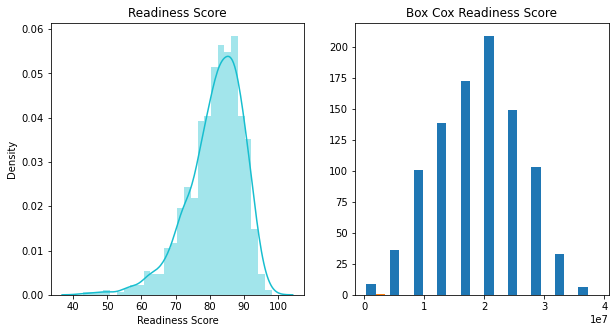

In [46]:
plt.figure(figsize = (10,5))

# original  
plt.subplot(1,2,1)
#sb.histplot(data = health_data_cleaned_num, x = 'Readiness Score', kde = True, edgecolor = "none", alpha = 0.3, color = color)
sb.distplot(health_data_cleaned_num['Readiness Score'], kde = True, color = color)
plt.title('Readiness Score');

# boxcox transformation - Bug histplot doesnt exists
from scipy import stats

plt.subplot(1,2,2)
boxcox_transformation = stats.boxcox(health_data_cleaned_num['Readiness Score'])
#sb.histplot(data = boxcox_transformation, kde = True, edgecolor = "none", alpha = 0.3, color = color)
#sb.distplot(boxcox_transformation, kde = True, color = color)
plt.hist(boxcox_transformation)
plt.title('Box Cox Readiness Score');


**Readiness Score**: The transformation results in a normally distributed curve by using the Box Cox method. Perhaps a bimodal pattern can spotted. This is recommended to be investigated further, however the variabel is exluded later in the analysis. 

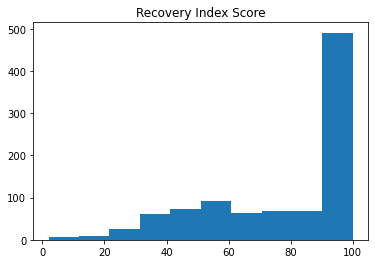

In [47]:
# original  - none of the transformations are working
#sb.histplot(data = health_data_cleaned_num, x = 'Recovery Index Score', kde = True, edgecolor = "none", alpha = 0.3, color = color)
plt.hist(health_data_cleaned_num['Recovery Index Score'])
plt.title('Recovery Index Score');


**Recovery Index Score**: No successful transformation is performed. This could also be due to bimodal behaviour, which will be investigated further. 

### Categorical Univariate Exploration

In [48]:
health_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 970
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         958 non-null    object 
 1   Season                       958 non-null    object 
 2   Sleep Score                  958 non-null    float64
 3   Total Sleep Score            958 non-null    float64
 4   REM Sleep Score              958 non-null    float64
 5   Deep Sleep Score             958 non-null    float64
 6   Sleep Efficiency Score       958 non-null    float64
 7   Restfulness Score            958 non-null    float64
 8   Sleep Latency Score          958 non-null    float64
 9   Sleep Timing Score           958 non-null    float64
 10  Total Bedtime                958 non-null    float64
 11  Total Sleep Time             958 non-null    float64
 12  Awake Time                   958 non-null    float64
 13  REM Sleep Time      

In [49]:
# change datatype of year to object
health_data_cleaned.Year = health_data_cleaned.Year.astype('str')

In [50]:
# create sub df with categorical dtypes
health_data_cleaned_cat = health_data_cleaned.select_dtypes(include = 'object')
health_data_cleaned_cat.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 970
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Date                    958 non-null    object
 1   Season                  958 non-null    object
 2   Bedtime Start           958 non-null    object
 3   Bedtime End             958 non-null    object
 4   Infradian Rythm (Data)  958 non-null    object
 5   Year                    958 non-null    object
dtypes: object(6)
memory usage: 52.4+ KB


In [51]:
# create categorical dtypes
health_data_cleaned_cat = health_data_cleaned_cat.astype('category')



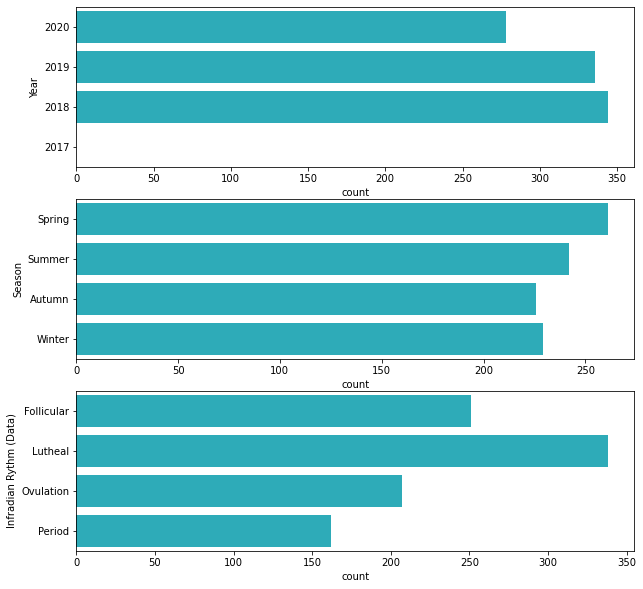

In [52]:
plt.figure(figsize = (10,10))

# Year

#plot
plt.subplot(3,1,1)

# sort categorical dtypes
order = ['2020', '2019', '2018', '2017']
sb.countplot(data = health_data_cleaned_cat, y = 'Year', order = order, color = color);

#Season
plt.subplot(3,1,2)
order = ['Spring', 'Summer', 'Autumn', 'Winter']
sb.countplot(data = health_data_cleaned_cat, y = 'Season', order = order, color = color);

# Infradian Rythm
plt.subplot(3,1,3)
order = ['Follicular', 'Ovulation', 'Lutheal', 'Period']
sb.countplot(data = health_data_cleaned_cat, y = 'Infradian Rythm (Data)', color = color);

#plt.title('Categorical Univariate Distributions');


**Year**: The data is collected during 3 years in compound time and 4 calendar years. 

**Season**: The data set contains data from all seasons in equal amounts. 

**Infradian Rythm**: The data set contains data from all phases of the menstrual cycle. There are more days of lutheal data than average data per phase and there are less data of periods than average data per phase. 

## Evaluation of Response Variable

In [53]:
health_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 970
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         958 non-null    object 
 1   Season                       958 non-null    object 
 2   Sleep Score                  958 non-null    float64
 3   Total Sleep Score            958 non-null    float64
 4   REM Sleep Score              958 non-null    float64
 5   Deep Sleep Score             958 non-null    float64
 6   Sleep Efficiency Score       958 non-null    float64
 7   Restfulness Score            958 non-null    float64
 8   Sleep Latency Score          958 non-null    float64
 9   Sleep Timing Score           958 non-null    float64
 10  Total Bedtime                958 non-null    float64
 11  Total Sleep Time             958 non-null    float64
 12  Awake Time                   958 non-null    float64
 13  REM Sleep Time      

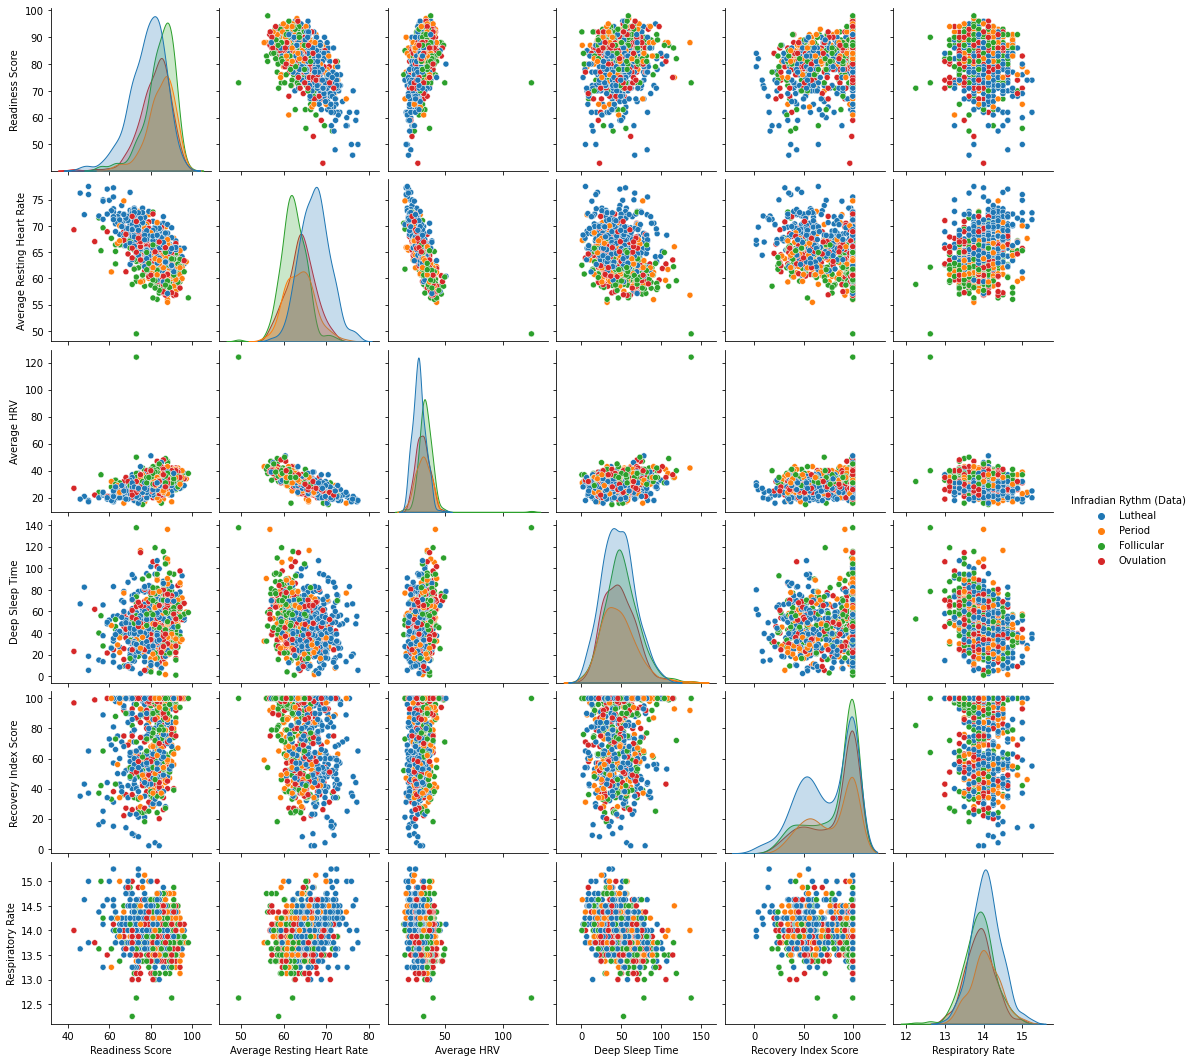

In [54]:
### Determination of key response variable
# 'Recovery Index Score' # Is not normally distributed
# 'Average HRV' and 'Average Resting Heart Rate' show clear correlation, so one is enough
# 'Respiratory Rate' is not believed to be the major focus of this analysis
candidates = health_data_cleaned[['Readiness Score', 'Average Resting Heart Rate', 'Average HRV', 'Deep Sleep Time', 'Recovery Index Score', 'Respiratory Rate', 'Infradian Rythm (Data)']]
sb.pairplot(candidates, hue = 'Infradian Rythm (Data)', palette = color_pal_r);


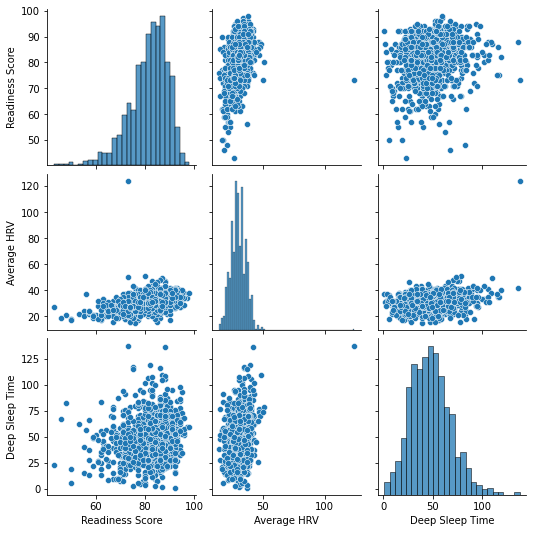

In [55]:
### Determination of key response variable
# 'Recovery Index Score' # Is not normally distributed
# 'Average HRV' and 'Average Resting Heart Rate' show clear correlation, so one is enough
# 'Respiratory Rate' is not believed to be the major focus of this analysis
# From 3D multivariate analysis 'Average HRV' and 'Average Respiratory Rate' shows the greatest impact of 
candidates = health_data_cleaned[['Readiness Score', 'Average HRV', 'Deep Sleep Time']]
sb.pairplot(candidates);


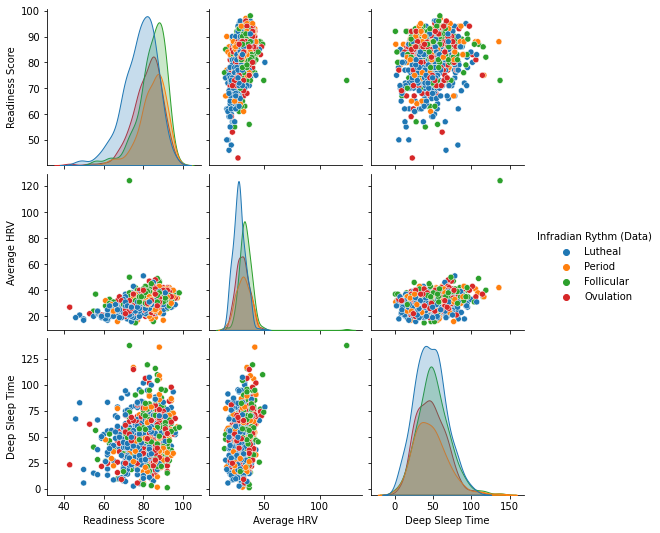

In [56]:
# multivariate determination of key response variable
# 'Recovery Index Score' # Is not normally distributed
# 'Average HRV' and 'Average Resting Heart Rate' show clear correlation, so one is enough
# 'Respiratory Rate' is not believed to be the major focus of this analysis
candidates = health_data_cleaned[['Readiness Score', 'Average HRV', 'Deep Sleep Time', 'Infradian Rythm (Data)']]
sb.pairplot(candidates, hue = 'Infradian Rythm (Data)', palette = color_pal_r);



In [57]:
response_var = health_data_cleaned['Average HRV']

### Choise of Response Variable
In professional cases, I would ask the physiological expert for support in determination of response variabel. This time, a quick analysis was made to detemine any potentional response.

Of the suggested response variables (Readiness Score, RHR, Respiratory Rate, HRV, Deep Sleep, Recovery Index Score)  

From the uni- and bivariate plots following parameters were excluded:
- 'Recovery Index Score' is not normally distributed
- 'Average HRV' and 'Average Resting Heart Rate' show clear correlation. Therefore, one is enough, 'Average Resting Heart Rate' is excluded.
- 'Respiratory Rate' is not believed to be the major focus of this analysis

Of the three remaining **Average HRV** was chosen because of the multivariate plots revealing patterns of the menstrual cycle.

## Bivariate Exploration

> This section is divided into two parts:
> 1. Numerical Univariate Exploration
> 2. Categorical Bivariate Exploration

### Bivariate Numeric Exploration

In [ ]:
# Quick Screening 
sb.pairplot(health_data_cleaned);

In [ ]:
health_data_cleaned_num.info()

In [ ]:
health_data_cleaned_var = health_data_cleaned_num[health_data_cleaned_num.columns[health_data_cleaned_num.columns != 'Average HRV']]


In [ ]:
health_data_cleaned_num.describe().round(2)

In [ ]:
# numeric bivariate plots

for col in health_data_cleaned_var:
    plt.figure(figsize = (8,5))
    sb.regplot(data = health_data_cleaned_num, x = col, y = 'Average HRV', color = color)
    plt.title(col)
    

### Bivariate Numeric Results
_Positive Correlation_
- **Readiness Score** shows a high and wide positive correlation to Average HRV, tendency to exponential relationship. (approx. 17 - 37 = 20)
- **Deep Sleep Time** shows a wide and positive correlation to Average HRV. (approx. 26 - 37 = 11)
- **Recovery Index Score** shows a wide, slightly positive relationship to Average HRV. (approx. 25 - 32 = 7)
- **Steps** show a slight but surprisingly low positive correlation to Average HRV. (approx. 29 - 31 = 2)

_Negative Correlation_
- **Average Resting Heart Rate** shows a narrow negative linear correlation with Average HRV, a slight tendency to logarithmic relationship might be spotted but over all its a good fit to the linearity. (approx. 14 - 42 = 28)
- **Respiratory Rate** shows a wide, slightly negative correlation to Average HRV. (approx. 37 - 27 = 10)
- **Temperature Deviation (°C)** shows a wide but negative correlation to Average HRV.  (approx. 25 - 37 = 12)
No correlation
- **Activity Score** show surprisingly no correlation with Average HRV. (approx. 0)


In [ ]:
health_data_cleaned_cat.insert(0, 'Average HRV', health_data_cleaned['Average HRV'])
health_data_cleaned_cat.info()                    
                             
                             

### Bivariate Categorical Exploration

In [ ]:
# categoric bivariate plots
plt.figure(figsize = (15,15))

# year
plt.subplot(3,2,1)
sb.violinplot(data = health_data_cleaned_cat, x = 'Year', y = 'Average HRV', color = color);
plt.title('Year')
plt.subplot(3,2,2)
sb.boxplot(data = health_data_cleaned_cat, x = 'Year', y = 'Average HRV', color = color);
plt.title('Year')

# season
order = ['Spring', 'Summer', 'Autumn', 'Winter']
plt.subplot(3,2,3)
sb.violinplot(data = health_data_cleaned_cat, x = 'Season', y = 'Average HRV', order = order, color = color);
plt.title('Season')
plt.subplot(3,2,4)
sb.boxplot(data = health_data_cleaned_cat, x = 'Season', y = 'Average HRV', order = order, color = color);
plt.title('Season')

# cycle
order = ['Follicular', 'Ovulation', 'Lutheal', 'Period']
plt.subplot(3,2,5)
sb.violinplot(data = health_data_cleaned_cat, x = 'Infradian Rythm (Data)', y = 'Average HRV', order = order, color = color);
plt.title('Infradian Rythm (Data)')
plt.subplot(3,2,6)
sb.boxplot(data = health_data_cleaned_cat, x = 'Infradian Rythm (Data)', y = 'Average HRV', order = order, color = color);
plt.title('Infradian Rythm (Data)');

### Bivariate Categorical Results

None of the categoric variables show significant difference in Average HRV. However, patterns in the violin and box plots can still be found in the data. 

**Year**:
No statistical difference is found (25 - 30).
- For this person, 2017 was a worse year health wise than 2018, 2019 and 2020. 
- 2019 reveals large variation in both the reliving and stress direction.

**Season**:
No statistical difference is found (~ 2)
- The average values are quite equal for all seasons.
- The variation however differ; spring, summer and autumn have all higher variation in the Average HRV than the winter season.

**Infradian Rythm Phase**:
No statistical difference is found, however patterns can be found in the data (27 - 33).
- The follicular phase shows (insignificant) highest Average HRV
- The lutheal phase shows (insignificant) lowest Average HRV 
These findings are very consistent with the experience of these phases.


### Bivariate Summary
The maximum effect on Average HRV seem to correlate most with:
1. **Average Resting Heart Rate** 
2. **Readiness Score**
3. **Temperature Deviation (°C)**
4. **Deep Sleep Score**
5. **Respiratory Rate** 
6. **Recovery Index Score** 
7. **Infradian Rythm** 
8. **Year** 
9. **Season** 
10. **Steps** 

Surprisingly, the activity score did not seem to correlate with Average HRV at all. 

### Other Observations
2017 seemed to be a tough year for this person, this could possibly be due to the season of data collection which was october to december.





## Multivariate Exploration


In [ ]:
# Year
candidates = health_data_cleaned[['Average Resting Heart Rate', 'Readiness Score', 'Temperature Deviation (°C)', 'Average HRV', 'Deep Sleep Time', 'Respiratory Rate', 'Recovery Index Score', 'Steps', 'Activity Score', 'Year']]
sb.pairplot(candidates, hue = 'Year', palette = color_pal_r);


From the 3D-matrix plot of the Year and numerical variables, the correlations is found between the Year and all other variables except from:
- **Temperature Deviation (°C)**
- **Recovery Index Score** 

In [ ]:
# Infradian Rythm (Data)
candidates = health_data_cleaned[['Average Resting Heart Rate', 'Readiness Score', 'Temperature Deviation (°C)', 'Average HRV', 'Deep Sleep Time', 'Respiratory Rate', 'Recovery Index Score', 'Steps', 'Activity Score', 'Infradian Rythm (Data)']]
sb.pairplot(candidates, hue = 'Infradian Rythm (Data)', palette = color_pal_r);


From the 3D-matrix plot of the Infradian Rythm and numerical variables, the correlations is found between the Infradian Rythm and following variabels:
1. **Temperature Deviation (°C)**
2. **Average Resting Heart Rate** 
3. **Average HRV**
4. **Readiness Score**

The Recovery Index Score has a distribution which can not be explained by the Infradian Rythm. 

In [ ]:
# Season
candidates = health_data_cleaned[['Average Resting Heart Rate', 'Readiness Score', 'Temperature Deviation (°C)', 'Average HRV', 'Deep Sleep Time', 'Respiratory Rate', 'Recovery Index Score', 'Steps', 'Activity Score', 'Season']]
sb.pairplot(candidates, hue = 'Season', palette = color_pal);


From the 3D-matrix plot of the Season and numerical variables, a correlation is not found on any variable.

In [ ]:
# Simple plot for presentation
subset = health_data_cleaned[['Average HRV', 'Steps', 'Season', 'Infradian Rythm (Data)']]
plt.figure(figsize = (15,10));
sb.pairplot(subset, hue = 'Season', palette = color_pal);
plt.title('Multivariate plot: Average HRV, Steps and Season');


In [ ]:
# Simple plot for presentation
subset = health_data_cleaned[['Average HRV', 'Steps', 'Season', 'Infradian Rythm (Data)']]
sb.pairplot(subset, hue = 'Infradian Rythm (Data)', palette = color_pal);
plt.title('Multivariate plot: Average HRV, Steps and Infradian Rythm Phase');



In [ ]:
# Infradian Rythm and Year - Average HRV
fig = plt.figure(figsize = (20,10))

# order categorical data
health_data_cleaned.Year = pd.Categorical(health_data_cleaned.Year, categories = [ '2020', '2019', '2018', '2017'], ordered = True)
health_data_cleaned['Infradian Rythm (Data)'] = pd.Categorical(health_data_cleaned['Infradian Rythm (Data)'], categories = ['Period', 'Follicular', 'Ovulation', 'Lutheal'], ordered = True)
                                            
# Use group_by() and size() to get the number of cars and each combination of the two variable levels as a pandas Series
mean_HRV_categories = health_data_cleaned.groupby(['Infradian Rythm (Data)', 'Year']).mean()['Average HRV']
# print('1: ', mean_HRV_categories)

# Use Series.reset_index() to convert a series into a dataframe object
mean_HRV_categories = mean_HRV_categories.reset_index(name='HRV_mean')
# print('2: ', mean_HRV_categories)

# Use DataFrame.pivot() to rearrange the data, to have color on rows
mean_HRV_categories = mean_HRV_categories.pivot(index = 'Year' , columns = 'Infradian Rythm (Data)', values = 'HRV_mean')
# print('3: ', mean_HRV_categories)

# Convert HRV to int
mean_HRV_categories = mean_HRV_categories.round(1)
#print('4: ', mean_HRV_categories, mean_HRV_categories.info())

# sb.choose_diverging_palette()
cmap = sb.diverging_palette(19, 201, 53, 60, 18, 9, as_cmap=True)

# Plot the heatmap
plt.subplot(2,2,1)
sb.heatmap(mean_HRV_categories, cmap = cmap, annot = False, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels (Average HRV) for Menstrual Phases and Years (n=1, 3 years)', pad = 8);
plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");

plt.subplot(2,2,3)
sb.heatmap(mean_HRV_categories, cmap = cmap, annot = True, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels (Average HRV) for Menstrual Phases and Years (n=1, 3 years)', pad = 8);
plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");


# Infradian Rythm and Season
# order categorical data
health_data_cleaned.Season = pd.Categorical(health_data_cleaned.Season, categories = ['Spring', 'Summer', 'Autumn', 'Winter'], ordered = True)
health_data_cleaned['Infradian Rythm (Data)'] = pd.Categorical(health_data_cleaned['Infradian Rythm (Data)'], categories = ['Period', 'Follicular', 'Ovulation', 'Lutheal'], ordered = True)
                                            
# Use group_by() and size() to get the number of cars and each combination of the two variable levels as a pandas Series
mean_HRV_categories = health_data_cleaned.groupby(['Infradian Rythm (Data)', 'Season']).mean()['Average HRV']
# print('1: ', mean_HRV_categories)

# Use Series.reset_index() to convert a series into a dataframe object
mean_HRV_categories = mean_HRV_categories.reset_index(name='HRV_mean')
# print('2: ', mean_HRV_categories)

# Use DataFrame.pivot() to rearrange the data, to have color on rows
mean_HRV_categories = mean_HRV_categories.pivot(index = 'Season' , columns = 'Infradian Rythm (Data)', values = 'HRV_mean')
# print('3: ', mean_HRV_categories)

# Convert HRV to int
mean_HRV_categories = mean_HRV_categories.round(1)
#print('4: ', mean_HRV_categories, mean_HRV_categories.info())

# sb.choose_diverging_palette()
cmap = sb.diverging_palette(19, 201, 53, 60, 18, 9, as_cmap=True)

# Plot the heatmap
plt.subplot(2,2,2)
sb.heatmap(mean_HRV_categories, cmap = cmap, annot = False, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels (Average HRV) for Menstrual Phases and Seasons (n=1, 3 years)', pad = 8);
plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");

plt.subplot(2,2,4)
sb.heatmap(mean_HRV_categories, cmap = cmap, annot = True, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels (Average HRV) for Menstrual Phases and Seasons (n=1, 3 years)', pad = 8);
plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");

fig.tight_layout()

Overall, a quite large impact of the infradian rythm stage is indicated on Average HRV with the follicular phase as the best and the lutheal phase as the worst. This is in line with the expectations.

The heatmap to the left, shows that years have an impact on Average HRV levels, a result consistent with the bivariate analysis. Thus, its also consistents with the month of data collection. 2017 contains only autumn and winter data and 2020 contain less of data from this time. An average of the two years would yield similar results as 2018 and 2019. Consequecntly, year as an impact factor does not seems to be as large as the data shows.

The heatmap to the right indicates that season is a surpisingly moderate impact factor for this person (even if the results are non-significant statistically).



In [ ]:
# Additional copy for the presentation
# Infradian Rythm and Season
# order categorical data
health_data_cleaned.Season = pd.Categorical(health_data_cleaned.Season, categories = ['Spring', 'Summer', 'Autumn', 'Winter'], ordered = True)
health_data_cleaned['Infradian Rythm (Data)'] = pd.Categorical(health_data_cleaned['Infradian Rythm (Data)'], categories = ['Period', 'Follicular', 'Ovulation', 'Lutheal'], ordered = True)
                                            
# Use group_by() and size() to get the number of cars and each combination of the two variable levels as a pandas Series
mean_HRV_categories = health_data_cleaned.groupby(['Infradian Rythm (Data)', 'Season']).mean()['Average HRV']
# print('1: ', mean_HRV_categories)

# Use Series.reset_index() to convert a series into a dataframe object
mean_HRV_categories = mean_HRV_categories.reset_index(name='HRV_mean')
# print('2: ', mean_HRV_categories)

# Use DataFrame.pivot() to rearrange the data, to have color on rows
mean_HRV_categories = mean_HRV_categories.pivot(index = 'Season' , columns = 'Infradian Rythm (Data)', values = 'HRV_mean')
# print('3: ', mean_HRV_categories)

# Convert HRV to int
mean_HRV_categories = mean_HRV_categories.round(1)
#print('4: ', mean_HRV_categories, mean_HRV_categories.info())

# sb.choose_diverging_palette()
cmap = sb.diverging_palette(19, 201, 53, 60, 18, 9, as_cmap=True)

# plot the heatmap
plt.figure(figsize=(10,5))
sb.heatmap(mean_HRV_categories, cmap = cmap, annot = True, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels for Menstrual Phases and Seasons (n=1, 3 years)', pad = 8);

plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");



In [ ]:
# Additional copy for the presentation
# Infradian Rythm and Season
# order categorical data
health_data_cleaned.Season = pd.Categorical(health_data_cleaned.Season, categories = ['Spring', 'Summer', 'Autumn', 'Winter'], ordered = True)
health_data_cleaned['Infradian Rythm (Data)'] = pd.Categorical(health_data_cleaned['Infradian Rythm (Data)'], categories = ['Period', 'Follicular', 'Ovulation', 'Lutheal'], ordered = True)
                                            
# Use group_by() and size() to get the number of cars and each combination of the two variable levels as a pandas Series
mean_HRV_categories = health_data_cleaned.groupby(['Infradian Rythm (Data)', 'Season']).mean()['Average HRV']
# print('1: ', mean_HRV_categories)

# Use Series.reset_index() to convert a series into a dataframe object
mean_HRV_categories = mean_HRV_categories.reset_index(name='HRV_mean')
# print('2: ', mean_HRV_categories)

# Use DataFrame.pivot() to rearrange the data, to have color on rows
mean_HRV_categories = mean_HRV_categories.pivot(index = 'Season' , columns = 'Infradian Rythm (Data)', values = 'HRV_mean')
# print('3: ', mean_HRV_categories)

# Convert HRV to int
mean_HRV_categories = mean_HRV_categories.round(1)
#print('4: ', mean_HRV_categories, mean_HRV_categories.info())

# sb.choose_diverging_palette()
cmap = sb.diverging_palette(19, 201, 53, 60, 18, 9, as_cmap=True)

# plot the heatmap
plt.figure(figsize=(10,5))
sb.heatmap(mean_HRV_categories, cmap = cmap, cbar_kws={'label': 'Average HRV'});
plt.title('Wellness Levels for Menstrual Phases and Seasons (n=1, 3 years)', pad = 8);
plt.yticks(np.arange(4)+0.5, rotation=90, fontsize="10", va="center");



In [ ]:
# boxplot
colors = sb.color_palette('YlGnBu')[1:6]

# plot
plt.figure(figsize=(10,7))
sb.boxplot(data = health_data_cleaned, x = 'Infradian Rythm (Data)', y = 'Average HRV', hue = 'Season', palette = colors)
plt.xlabel('Infradian Rythm Phase')
plt.ylabel('Average HRV (ms)')
leg = plt.legend(title='Season');
plt.title('Wellness Levels for Menstrual Phases and Seasons (n=1, 3 years)')

# estetics
# extract the spines and make them invisible
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
leg._legend_box.align = 'left'

While the heatmap shows means of the Average HRV, the boxplot shows the mean, interquartile range and the range for each square in the heatmap. The boxplot shows the insignificance of each box, however, a pattern ca still be seen with somewhat higher values in the follicular phase and lower in the lutheal phase. Spring, summer and autumn all show higher values than winter for all Infradian Rythm Phases. 




### Statistical significance - Linear regression model

In [ ]:
import statsmodels.api as sm

# Create intercept for the regression model
subset['Intercept'] = 1

subset.info()

In [ ]:
# For categorical data - Create dummy variables
subset[subset.Season.unique()] = pd.get_dummies(subset['Season'])
subset[subset['Infradian Rythm (Data)'].unique()] = pd.get_dummies(subset['Infradian Rythm (Data)'])
subset


In [ ]:
# Linear model creation - steps - R2 0.005, steps sign with coef 0.0001 
Y = subset['Average HRV']
X = subset[['Intercept', 'Steps']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
# Linear model creation - seasons R2 = 0.019; summer (29.0438), spring (2.2591) and autumn (1.0380) showed sign! 
Y = subset['Average HRV']
X = subset[['Intercept', 'Winter',
 'Spring',
 'Autumn']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
# model creation - cycle phases R2 = 0.120; follicular (33.0604), ovulation (-5.2450), lutheal (-2.7270) and period (-1.9361) showed sign! 
Y = subset['Average HRV']
X = subset[['Intercept',
 'Ovulation',
 'Lutheal',
 'Period']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
# model creation - multivariate adjusted - didnt help
Y = subset['Average HRV']
X = subset[['Intercept', 'Winter',
 'Spring',
 'Autumn',
 'Ovulation',
 'Lutheal',
 'Period']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
# model creation - multivariate 
Y = subset['Average HRV']
X = subset[['Intercept', 'Steps', 'Winter',
 'Spring',
 'Autumn',
 'Ovulation',
 'Lutheal',
 'Period']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
subset.info()

In [ ]:
# Interaction terms
subset['period_spring'] = subset.Period*subset.Spring
subset['period_summer'] = subset.Period*subset.Summer
subset['period_autumn'] = subset.Period*subset.Autumn
subset['period_winter'] = subset.Period*subset.Winter

subset['follicular_spring'] = subset.Follicular*subset.Spring
subset['follicular_summer'] = subset.Follicular*subset.Summer
subset['follicular_autumn'] = subset.Follicular*subset.Autumn
subset['follicular_winter'] = subset.Follicular*subset.Winter

subset['ovulation_spring'] = subset.Ovulation*subset.Spring
subset['ovulation_summer'] = subset.Ovulation*subset.Summer
subset['ovulation_autumn'] = subset.Ovulation*subset.Autumn
subset['ovulation_winter'] = subset.Ovulation*subset.Winter

subset['lutheal_spring'] = subset.Lutheal*subset.Spring
subset['lutheal_summer'] = subset.Lutheal*subset.Summer
subset['lutheal_autumn'] = subset.Lutheal*subset.Autumn
subset['lutheal_winter'] = subset.Lutheal*subset.Winter

subset
list(subset)


In [ ]:
# model creation - multivariate interaction terms
Y = subset['Average HRV']
X = subset[['Steps',
 'Intercept',
 'Winter',
 'Spring',
 'Autumn',
 'Ovulation',
 'Lutheal',
 'Period',
 'period_spring',
 'period_summer',
 'period_autumn',
 'period_winter',
 'follicular_spring',
 'follicular_summer',
 'follicular_autumn',
 'follicular_winter',
 'ovulation_spring',
 'ovulation_summer',
 'ovulation_autumn',
 'ovulation_winter',
 'lutheal_spring',
 'lutheal_summer',
 'lutheal_autumn',
 'lutheal_winter']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

In [ ]:
# model creation - multivariate interaction terms
Y = subset['Average HRV']
X = subset[['Intercept',
 'Spring',
 'Ovulation',
 'Lutheal',
 'Period',
 'period_summer',
 'lutheal_summer']]
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

### Conclusions

The multivariate analysis showed no statistical significant results. 

However patterns are found in the data as seen in heatmap showing means of Average HRV for different Infradian Rythm Phases och Seasons. The infradian Rythm seems to have a larger effect on Average HRV than Seasonal impact with the best performance or wellness in the follicular phase while the worst in the luthal phase. Summer seems to be the best season and winter the worst in the case of Average HRV. 

These patterns are in line with research in the field and with the clients experiences, which should not be underestimated. To create a personal wellness model Average HRV, Season and Infradian Rythm Phase could potentially be useful to predict performance and wellness on an individual level.

_Would life style adaption to the infradian rythm would be benefital to overall health and performance?_
- The analysis showed statistical non-significant differences in Average HRV of Infradian Rythm Phases and Seasons.

- If the person in question physiologically experience these differences, it would be recommended to adapt the lifestyle to Infradian Rythm with the (high) daily variation taken into account. 

- Daily monitoring or Average HRV and action according to the results, would be benefital for overall health and performance. Without daily monirtoring, the Infradian Rythm Phases could potentially act as a guide for the life style activities. 

### Further Analysis
Before recommendation of seasonal life style changes, I would recommend to investigate the cause of these.



In [ ]:
#!jupyter nbconvert health_data_exploration_report.ipynb --to slides --post serve --template output_toggle


In [ ]:
!jupyter nbconvert health_data_exploration_report.ipynb --to slides --SlidesExporter.reveal_scroll=True --post serve --no-input --no-prompt
